In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
pd.set_option('display.max_columns', None)
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump
from joblib import load
from sklearn.ensemble import RandomForestClassifier
import os
import shutil
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from scipy.stats import entropy
import itertools
import ast


# Task 1

In [37]:
file = 'answerList_data.csv'
df_original = pd.read_csv(file)
df_original["Answer.option"] = np.where(df_original["Answer.option"] == "YES", 1, 0)
df_original["isCorrect"] = np.where(df_original["Answer.option"] == df_original["GroundTruth"], 1, 0)
df_original

Answer.ID FailingMethod  Question.ID  Answer.duration  \
0           261       HIT01_8            0           90.984   
1           262       HIT01_8            0          133.711   
2           263       HIT01_8            0           77.696   
3           264       HIT01_8            0           46.644   
4           265       HIT01_8            0          215.416   
...         ...           ...          ...              ...   
2575       2316      HIT08_54          128          220.420   
2576       2317      HIT08_54          128          322.790   
2577       2318      HIT08_54          128          159.530   
2578       2319      HIT08_54          128           68.578   
2579       2320      HIT08_54          128           72.605   

      Answer.confidence  Answer.difficulty  GroundTruth  TP  TN  FN  FP  \
0                     4                  2            0   0   1   0   0   
1                     5                  1            0   0   1   0   0   
2                     5                  2            0   0   1   0   0   
3                     1                  1            0   0   1   0   0   
4                     5                  5            0   0   1   0   0   
...                 ...                ...          ...  ..  ..  ..  ..   
2575                  2                  4            0   0   1   0   0   
2576                  4                  3            0   0   0   0   1   
2577                  5                  1            0   0   1   0   0   
2578                  5                  1            0   0   1   0   0   
2579                  4                  4            0   0   1   0   0   

      Answer.option  Answer.order  \
0                 0             3   
1                 0             3   
2                 0             3   
3                 0             3   
4                 0             3   
...             ...           ...   
2575              0             1   
2576              1             1   
2577              0             1   
2578              0             1   
2579              0             2   

                                     Answer.explanation  Code.LOC  \
0     hoursOffset accepts negative numbers between -...         1   
1     the conditional clause is correct for the give...         1   
2     The argument -2 is within the range (-23;23); ...         1   
3     The exception is in no way related to the hour...         1   
4     The issue cannot be with hoursOffset since the...         1   
...                                                 ...       ...   
2575  I don't believe this line would be the cause o...         1   
2576  The line assumes that the string is a valid lo...         1   
2577  This line is after all cases that throw the ex...         1   
2578  The function never reaches this statement befo...         1   
2579  No it's not an issue the the return calls Loca...         1   

      Code.complexity                                  Worker.ID  \
0                   1              832cg-7G1i-462:73eI-8E-2g-985   
1                   1                              98ce7A-4i-507   
2                   1               881AC0I2E-625:135cI3E-7e8-86   
3                   1             270eG-5c6A3-46:65eI-2i-2I-9-36   
4                   1               844Cg1g5e1-17:255ei-8G8E85-8   
...               ...                                        ...   
2575                1                          1171ea-4g-6C-73-8   
2576                1             66AC-5a0g-47-9:1443IA-7C-6e967   
2577                1           106iG8G-9I-9-80:590CG-6G-7i-71-9   
2578                1  1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86   
2579                1                 1520Ea3c0E3-65:9AI0g4a-386   

      Worker.score       Worker.profession  Worker.yearsOfExperience  \
0                5   Undergraduate_Student                       7.0   
1                4   Undergraduate_Student                      10.0   
2                5  Professional_Develope

In [38]:
def calculate_halstead_volume(text):
    tokens = str(text).lower().split()
    types = set(tokens)
    halstead_volume = len(tokens) * math.log2(len(types)) 
    return halstead_volume

df_original['Halstead_volume'] = df_original['Answer.explanation'].apply(calculate_halstead_volume)

In [39]:
#split by worker profession. If profession is "Graduate_Student" or "Undergraduate_Student" then but them in student df ele in non student df
df_student = df_original[(df_original['Worker.profession'] == "Graduate_Student") | (df_original['Worker.profession'] == "Undergraduate_Student")]
df_non_student = df_original[(df_original['Worker.profession'] != "Graduate_Student") & (df_original['Worker.profession'] != "Undergraduate_Student")]

In [40]:
df_non_student_cleaned = df_non_student.drop(["Worker.profession", 'Answer.ID', 'Question.ID', 'GroundTruth', 'TP', 'TN', 'FN', 'FP', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.score','Answer.explanation', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)

In [41]:
churn_df = df_student.drop(["Worker.profession", 'Answer.ID', 'Question.ID', 'GroundTruth', 'TP', 'TN', 'FN', 'FP', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.score','Answer.explanation', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)
churn_df.head()

FailingMethod  Answer.duration  Answer.confidence  Answer.difficulty  \
0       HIT01_8           90.984                  4                  2   
1       HIT01_8          133.711                  5                  1   
4       HIT01_8          215.416                  5                  5   
5       HIT01_8          126.945                  5                  1   
6       HIT01_8          113.620                  4                  2   

   Worker.yearsOfExperience  isCorrect  Halstead_volume  
0                       7.0          1        62.510250  
1                      10.0          1        46.604513  
4                       5.0          1        66.417140  
5                      12.0          1       131.612312  
6                       4.0          1        76.000000

In [42]:
failing_methods = churn_df['FailingMethod'].unique()

holdout_methods = failing_methods[:2]
train_methods = failing_methods[2:]  


holdout_set = churn_df[churn_df['FailingMethod'].isin(holdout_methods)]
train_set = churn_df[churn_df['FailingMethod'].isin(train_methods)]


X_train = train_set.drop(columns=['isCorrect', 'FailingMethod'])
y_train = train_set['isCorrect']

X_holdout = holdout_set.drop(columns=['isCorrect', 'FailingMethod'])
y_holdout = holdout_set['isCorrect']


groups = train_set['FailingMethod']

In [43]:
# check if best_rf_model.joblib exists
if os.path.exists('best_rf_model.joblib'):
    best_rf = load('best_rf_model.joblib')
else:
    rf = RandomForestClassifier(random_state=42)

    param_grid = {'max_depth': [2,3,4,5,10,20,30,  None], 
                'min_samples_leaf': [1,2,3, 5, 10, 15, 30],
                'min_samples_split': [2,3,4,5],
                'max_features': [2,3,4,5],
                'n_estimators': [50, 75, 100, 125, 150, 200]
                }  

    scoring = ['accuracy', 'precision', 'recall', 'f1']

    group_kfold = GroupKFold(n_splits=5)


    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=group_kfold, 
                            scoring=scoring, refit="f1", n_jobs=-1, verbose=1)


    grid_search.fit(X_train, y_train, groups=groups)


    print(f"Best hyperparameters: {grid_search.best_params_}")

    best_rf = grid_search.best_estimator_
    dump(best_rf, 'best_rf_model.joblib')

In [44]:
shuffled_df_non_student = df_non_student_cleaned.copy()
shuffled_df_non_student = shuffled_df_non_student.sample(frac=1, random_state=42).reset_index(drop=True)

In [45]:
precision_scores = []
recall_scores = []
num_entries_added = []

current_holdout = holdout_set.copy()

for i in range(len(shuffled_df_non_student)):
    current_holdout = pd.concat([current_holdout, shuffled_df_non_student.iloc[[i]]])
    
    X_current_holdout = current_holdout.drop(columns=['isCorrect', 'FailingMethod'])
    y_current_holdout = current_holdout['isCorrect']
    
    y_pred_current = best_rf.predict(X_current_holdout)
    
    precision = precision_score(y_current_holdout, y_pred_current)
    recall = recall_score(y_current_holdout, y_pred_current)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    num_entries_added.append(i + 1) 



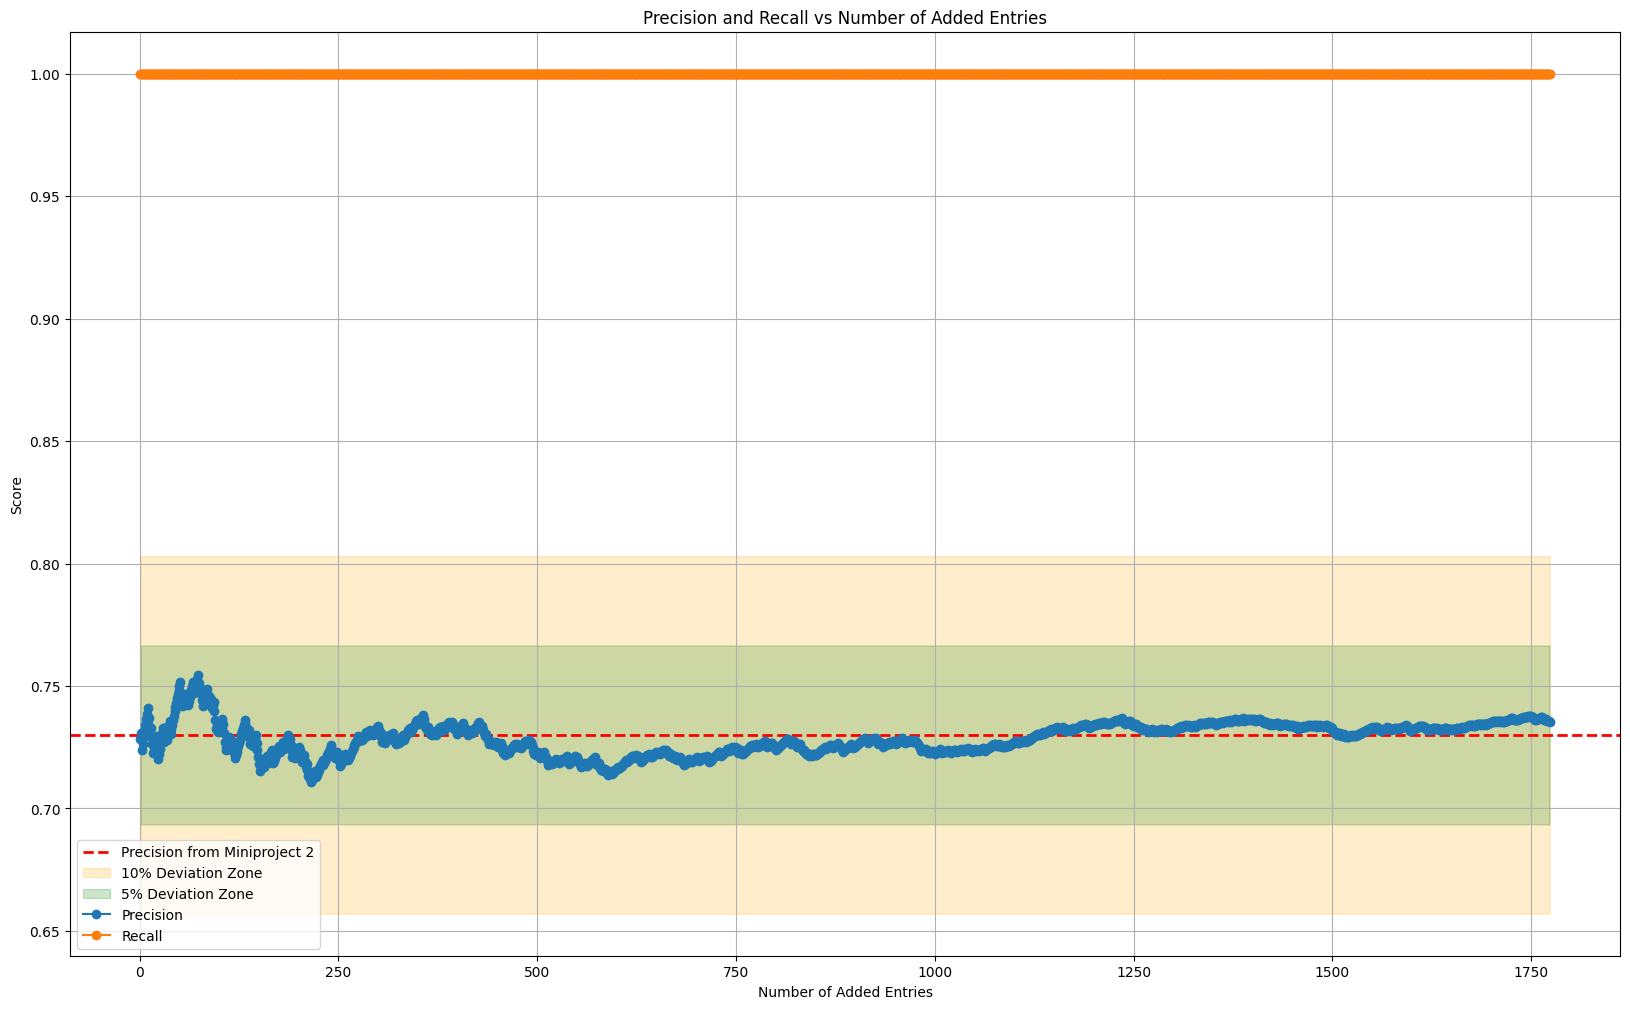

In [46]:
plt.figure(figsize=(20, 12))
baseline_precision = 0.73
plt.axhline(y=baseline_precision, color='red', linestyle='--', linewidth=2, label="Precision from Miniproject 2")
upper_5 = baseline_precision * 1.05
lower_5 = baseline_precision * 0.95
upper_10 = baseline_precision * 1.10
lower_10 = baseline_precision * 0.90
plt.fill_between(num_entries_added, lower_10, upper_10, color='orange', alpha=0.2, label="10% Deviation Zone")
plt.fill_between(num_entries_added, lower_5, upper_5, color='green', alpha=0.2, label="5% Deviation Zone")
plt.plot(num_entries_added, precision_scores, label="Precision", marker='o')
plt.plot(num_entries_added, recall_scores, label="Recall", marker='o')
plt.xlabel("Number of Added Entries")
plt.ylabel("Score")
plt.title("Precision and Recall vs Number of Added Entries")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print(f"First Precision Score: {precision_scores[0]}, First Recall Score: {recall_scores[0]}")

First Precision Score: 0.7281553398058253, First Recall Score: 1.0


# Task 2

In [48]:
df_tp = df_original[df_original['TP'] == 1]
df_tp

Answer.ID FailingMethod  Question.ID  Answer.duration  \
20          441       HIT01_8            1          140.407   
22          443       HIT01_8            1          112.409   
23          444       HIT01_8            1           76.418   
24          445       HIT01_8            1          261.928   
25          446       HIT01_8            1          236.045   
...         ...           ...          ...              ...   
2470       1771      HIT08_54          123          655.324   
2472       1773      HIT08_54          123          372.333   
2477       1778      HIT08_54          123         3905.721   
2478       1779      HIT08_54          123          498.361   
2479       1780      HIT08_54          123          309.258   

      Answer.confidence  Answer.difficulty  GroundTruth  TP  TN  FN  FP  \
20                    4                  3            1   1   0   0   0   
22                    5                  2            1   1   0   0   0   
23                    5                  1            1   1   0   0   0   
24                    5                  2            1   1   0   0   0   
25                    5                  1            1   1   0   0   0   
...                 ...                ...          ...  ..  ..  ..  ..   
2470                  4                  2            1   1   0   0   0   
2472                  4                  3            1   1   0   0   0   
2477                  5                  1            1   1   0   0   0   
2478                  5                  3            1   1   0   0   0   
2479                  5                  1            1   1   0   0   0   

      Answer.option  Answer.order  \
20                1             3   
22                1             3   
23                1             3   
24                1             3   
25                1             3   
...             ...           ...   
2470              1             1   
2472              1             1   
2477              1             1   
2478              1             1   
2479              1             1   

                                     Answer.explanation  Code.LOC  \
20    Minutes are set to -15; which is less then 0 a...         1   
22    In the code there is a check that 0 <= minutes...         1   
23    There is a logical check for if minuteOffset i...         1   
24    YES. The issue is on line 279 (as I explained ...         1   
25    The variable "minutesOffset" is checked incorr...         1   
...                                                 ...       ...   
2470  The fourth character must be the beginning of ...         3   
2472  It is checking the 3rd and 4th characters are ...         3   
2477  The comments say it validates strictly.  There...         3   
2478  The if statement in line 115 is checking the c...         3   
2479  ch3 will have a value (an underscore) that fal...         3   

      Code.complexity                                   Worker.ID  \
20                  1                            35Eg-6i-8G-2-6-8   
22                  1                               286Ig-9C0E170   
23                  1   1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86   
24                  1              555aC0a8e4-8-3:535CE8A-5e-95-2   
25                  1             815aA-9g-4e44-8:182Ae3g-6i-30-5   
...               ...                                         ...   
2470                2                               604Ic-1I5i105   
2472                2                              676ec6g2C1-2-9   
2477                2    67AI-8G5A71-3:163Aa0i0a963:161eg5c5I-649   
2478                2  21Ig2A-5e0-88:292CE-5a2c86-4:60ei9e-5I04-3   
2479                2                             71gE-6g-5A-3-20   

      Worker.score       Worker.profession  Worker.yearsOfExperience  \
20               3   Undergraduate_Student                       3.0   
22               5   Undergraduate_Student                       5.0   
23               4   Undergra

Create ground truth for every method by letting ChatGPT use all TP explanations and summarizing them with the best prompt from mini project 2:

"We have asked developers to find bugs in software and explain the bug to us. Based on the participants’ explanations, give us one very short explanation of the bug, while keeping the information that would be necessary for someone else to fix the bug. Write it in a way one of the participants would. These are the answers of the participants (one per line):"

In [49]:
if not os.path.exists("original_explanations_by_method"):

    os.makedirs("original_explanations_by_method")

    for method in failing_methods:
        df_method = df_tp[df_tp['FailingMethod'] == method]
        with open(f"original_explanations_by_method/{method}.txt", "w") as f:
            for explanation in df_method['Answer.explanation']:
                f.write(explanation + "\n")



Now to calculate the readibility, originally we wanted to use Simple Measure of Gobbledygook (SMOG) for the calculation which is a readibility score that is also used in more technical/specific contexts, however it is normed on 30-sentences samples which is obviously not given in our case.

We then settled on Flesch Reading Ease which is an actual score however it might be limited by the fact that it is developed for school books which probably lack the technical complexity present in bug reports. However, for comparing differences among the reports it might still be adequate


In [50]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('cmudict')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paul_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\paul_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\paul_\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [51]:
d = cmudict.dict()

def syllable_count(word):
    word = word.lower()
    if word in d:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in d[word]])
    else:
        return len([char for char in word if char in "aeiou"])

def flesch_reading_ease(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
  
    asl = len(words) / len(sentences)

    syllable_count_total = sum([syllable_count(word) for word in words])
    asw = syllable_count_total / len(words)
    
    fre = 206.835 - (1.015 * asl) - (84.6 * asw)
    return fre

In [52]:
#Average Flesh Reading Ease Score for each failing method from the original explanations
avg_read_score = []
for method in failing_methods:
    with open(f"original_explanations_by_method/{method}.txt", "r") as f:
        explanations = f.readlines()
        fre_scores = [flesch_reading_ease(explanation) for explanation in explanations]
        avg_fre = sum(fre_scores) / len(fre_scores)
        print(f"Average Flesch Reading Ease Score for {method}: {avg_fre}")
        avg_read_score.append(avg_fre)


Average Flesch Reading Ease Score for HIT01_8: 76.23885851730202
Average Flesch Reading Ease Score for HIT02_24: 67.41748042672367
Average Flesch Reading Ease Score for HIT03_6: 78.77002328462672
Average Flesch Reading Ease Score for HIT04_7: 71.57021819030521
Average Flesch Reading Ease Score for HIT05_35: 87.70003240072735
Average Flesch Reading Ease Score for HIT06_51: 87.10415780900463
Average Flesch Reading Ease Score for HIT07_33: 90.30790356615164
Average Flesch Reading Ease Score for HIT08_54: 97.23137313058065


In [53]:
#Flesch Reading Ease Score for each failing method from the ground truth explanations
gt_read_score = []
for method in failing_methods:
    with open(f"chatgpt_ground_truth_explanation/{method}.txt", "r") as f:
        explanations = f.readlines()
        fre_scores = [flesch_reading_ease(explanation) for explanation in explanations]
        print(f"Flesch Reading Ease Score for {method}: {fre_scores[0]}")
        gt_read_score.append(fre_scores[0])


Flesch Reading Ease Score for HIT01_8: 62.9487562189055
Flesch Reading Ease Score for HIT02_24: 57.45935742971888
Flesch Reading Ease Score for HIT03_6: 48.18179487179489
Flesch Reading Ease Score for HIT04_7: 38.85805031446543
Flesch Reading Ease Score for HIT05_35: 61.024891774891785
Flesch Reading Ease Score for HIT06_51: 70.03428571428573
Flesch Reading Ease Score for HIT07_33: 95.49598039215688
Flesch Reading Ease Score for HIT08_54: 83.9142307692308


In [54]:
shuffled_methods = {}
for method in failing_methods:
    with open(f"original_explanations_by_method/{method}.txt", "r") as f:
        explanations = f.readlines()

        random.seed(42)
        random.shuffle(explanations)

        shuffled_methods[method] = explanations

This dict is now determining the order in which the explanations are given to ChatGPT. The folder "chatgpt_consolidated_explanations_per_method" now contains a text file for each method with the first line in each text file representing an AI explanation with only the first correct user explanation, the second line being the AI explanation that has seen two correct user explanations and so on until the last line having seen all correct user explanations

In [55]:
for line in shuffled_methods["HIT08_54"]:
    print(line) 

Yes; if "fr__POSIX" has two underscores then the character at index 3 will lead to an exception being thrown.

ch3 is assigned a "_" value. This value throws a failure in line 115; as it is not a letter between A and Z.

else statement is missing

YOU MAY HAVE

ch3 is an underscore; not an A-Z character. These lines of code tell it to throw an error when ch3 is not A-Z.

The failure occurs during the execution of lines 115 - 116.  In line 113; ch3 is set to be "_".  In the if statement of line 115; ch3 is checked for being less than 'A'; which is false; but it is also checked for being greater than 'Z'; and it turns out that the value for '_' is greater than 'Z'.  Since this is so; this particular if statement executes; and throws out the failure outlined above.

Given that the format of the locale appears to be cc__CCCCC (c for character); the third character of the locale will always contain an underscore. Which in ASCII has a greater value than 'Z' causing the "ch3 > 'Z'" portion of

In [56]:
def cosine_similarity_score(text1, text2):
    vectorizer = CountVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0][1]


In [57]:
#Average Cosine Similarity Score for each failing method from the original explanations

avg_similarity_scores = []

for method in failing_methods:
    with open(f"original_explanations_by_method/{method}.txt", "r") as f:
        original_explanations = f.readlines()
    
    with open(f"chatgpt_ground_truth_explanation/{method}.txt", "r") as f:
        gt_explanations = f.readlines()
    
    similarity_scores = [cosine_similarity_score(original_explanations[i], gt_explanations[0]) for i in range(len(original_explanations))]
    avg_similarity = sum(similarity_scores) / len(similarity_scores)
    print(f"Average Cosine Similarity Score for {method}: {avg_similarity}")
    avg_similarity_scores.append(avg_similarity)


Average Cosine Similarity Score for HIT01_8: 0.32728926893563426


Average Cosine Similarity Score for HIT02_24: 0.36000629791340927
Average Cosine Similarity Score for HIT03_6: 0.3706864398748269
Average Cosine Similarity Score for HIT04_7: 0.29932930933281204
Average Cosine Similarity Score for HIT05_35: 0.42084348073311856
Average Cosine Similarity Score for HIT06_51: 0.3839964706243953
Average Cosine Similarity Score for HIT07_33: 0.37929622921073597
Average Cosine Similarity Score for HIT08_54: 0.3845515149592303


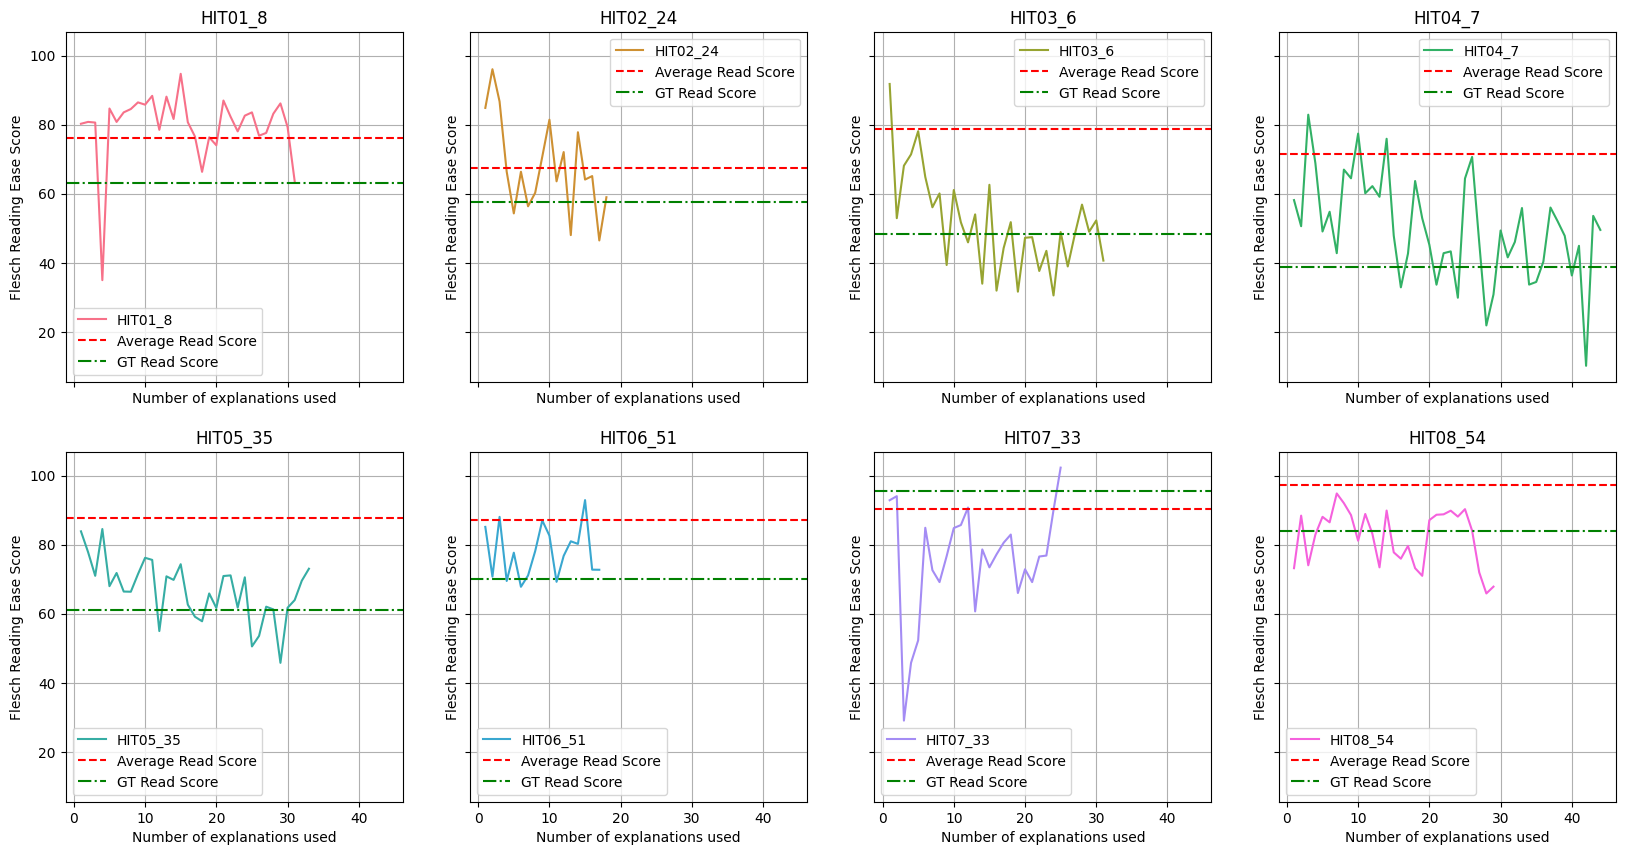

In [58]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

for i, method in enumerate(failing_methods):
    with open(f"chatgpt_consolidated_explanations_per_method/{method}.txt", "r") as f:
        explanations = f.readlines()
        fre_scores = [flesch_reading_ease(explanation) for explanation in explanations]
        row, col = divmod(i, 4)
        axs[row, col].plot(range(1, len(fre_scores) + 1), fre_scores, label=method, color=sns.color_palette("husl", len(failing_methods))[i])
        axs[row, col].axhline(y=avg_read_score[i], color='r', linestyle='--', label='Average Read Score')
        axs[row, col].axhline(y=gt_read_score[i], color='g', linestyle='-.', label='GT Read Score')
        axs[row, col].set_title(method)
        axs[row, col].grid(True)
        axs[row, col].set_xlabel("Number of explanations used")
        axs[row, col].set_ylabel("Flesch Reading Ease Score")
        axs[row, col].legend()

plt.show()


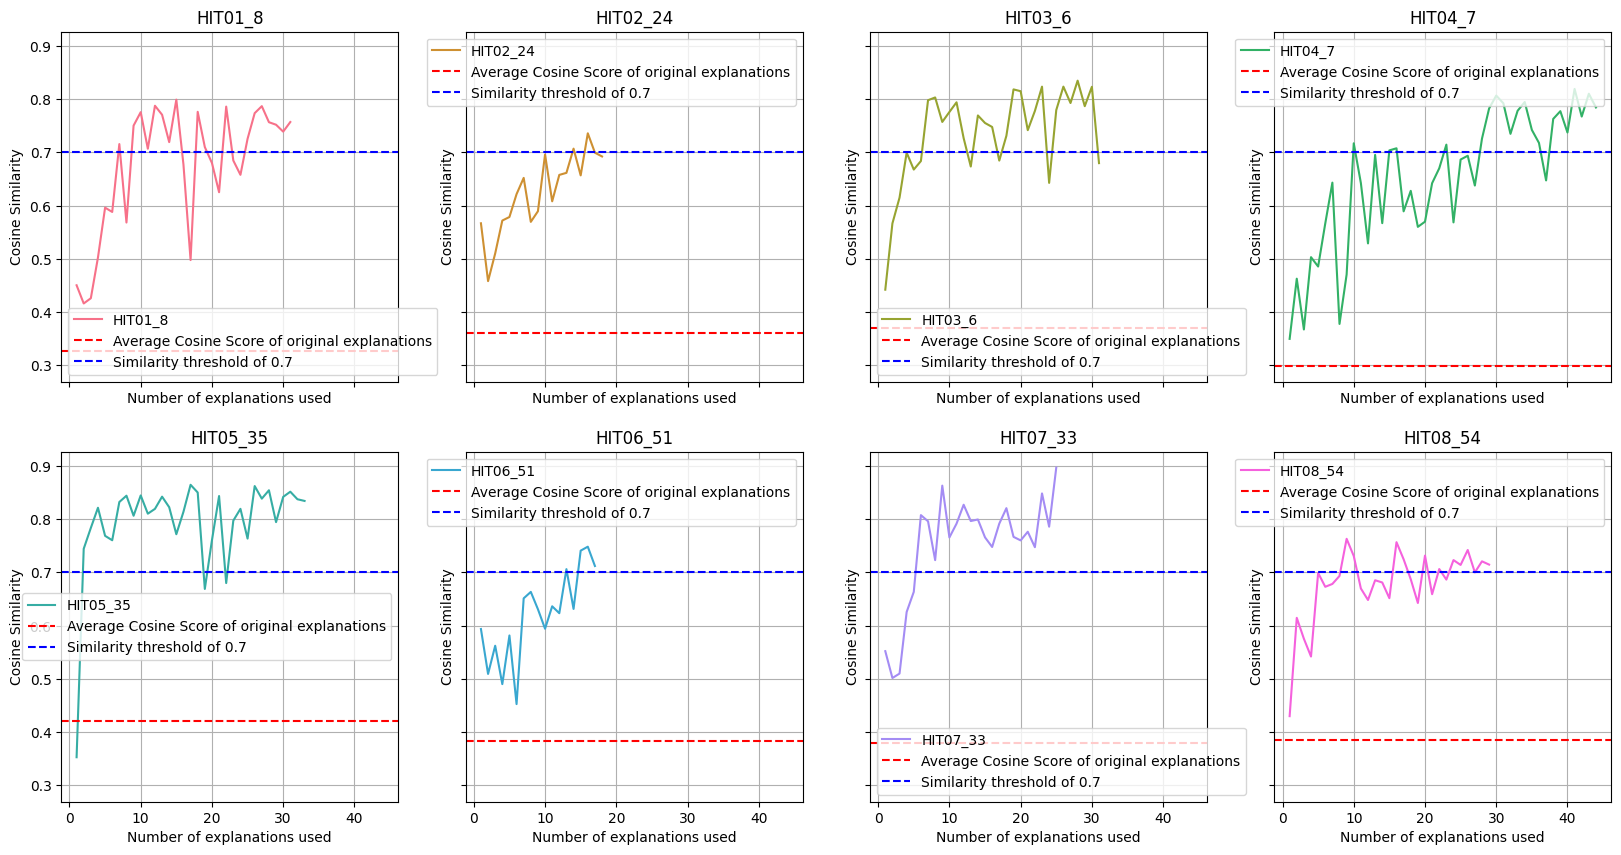

In [59]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True,  sharex=True)

over_threshold_index = []

for i, method in enumerate(failing_methods):
    with open(f"chatgpt_ground_truth_explanation/{method}.txt", "r") as f:
        gt_explanations = f.readlines()

    with open(f"chatgpt_consolidated_explanations_per_method/{method}.txt", "r") as f:
        explanations = f.readlines()
        similarity_scores = [cosine_similarity_score(explanations[i], gt_explanations[0]) for i in range(len(explanations))]
        row, col = divmod(i, 4)
        axs[row, col].plot(range(1, len(similarity_scores) + 1), similarity_scores, label=method, color=sns.color_palette("husl", len(failing_methods))[i])
        axs[row, col].axhline(y=avg_similarity_scores[i], color='r', linestyle='--', label='Average Cosine Score of original explanations')
        axs[row, col].axhline(y=0.7, color='b', linestyle='--', label='Similarity threshold of 0.7')
        axs[row, col].set_title(method)
        axs[row, col].grid(True)
        axs[row, col].set_xlabel("Number of explanations used")
        axs[row, col].set_ylabel("Cosine Similarity")
        axs[row, col].legend()

        first_exceeding_index = next((index for index, score in enumerate(similarity_scores) if score > 0.7), None)
        over_threshold_index.append(first_exceeding_index)

plt.show()

In [60]:
#Average number of explanations needed to exceed the threshold of 0.7
print(f"Average number of explanations needed to exceed the threshold of 0.7: {sum(over_threshold_index) / len(over_threshold_index)}")

Average number of explanations needed to exceed the threshold of 0.7: 7.5


# Task 3

In [61]:
avg_explanation_length = []
gt_explanation_length = []

for method in failing_methods:
    with open(f"original_explanations_by_method/{method}.txt", "r") as f:
        explanations = f.readlines()
        avg_length = sum([len(explanation) for explanation in explanations]) / len(explanations)
        avg_explanation_length.append(avg_length)
    
    with open(f"chatgpt_ground_truth_explanation/{method}.txt", "r") as f:
        explanation = f.readlines()[0]
        gt_explanation_length.append(len(explanation))

print(avg_explanation_length)
print(gt_explanation_length)


length_ratio = [ gt_explanation_length[i] / avg_explanation_length[i]  for i in range(len(failing_methods))]
print(length_ratio)


[172.09677419354838, 155.44444444444446, 173.06451612903226, 159.27272727272728, 171.6060606060606, 149.64705882352942, 113.24, 184.17241379310346]
[359, 428, 365, 338, 393, 326, 273, 353]
[2.0860356138706653, 2.7533952823445316, 2.109040074557316, 2.122146118721461, 2.2901289069397848, 2.1784591194968552, 2.4108089014482514, 1.9166822692379704]


In [62]:
def generate_combinations(explanations):
    return [(combo, ' '.join(combo)) for i in range(1, 6) for combo in itertools.combinations(explanations, i)]

def process_method(method):
    results = []

    method_df = df_tp[df_tp["FailingMethod"] == method]
    explanations = method_df["Answer.explanation"].tolist()
    
    combinations = generate_combinations(explanations)
    
    with open(f"chatgpt_ground_truth_explanation/{method}.txt", "r") as f:
        gt_explanation = f.readlines()
    
    for combo, combined_text in combinations:
        readability_score = flesch_reading_ease(combined_text)
        similarity_score = cosine_similarity_score(combined_text, gt_explanation[0])
        results.append({
            "Method": method,
            "Combination": combo,
            "CombinedText": combined_text,
            "ReadabilityScore": readability_score,
            "CosineSimilarity": similarity_score,
            "AverageScore": ((readability_score / 100) + similarity_score) / 2
        })

    results_df = pd.DataFrame(results)

    
    return results_df


for method in failing_methods:
    if not os.path.exists(f"combined_explanations_and_metrics/task_3_{method}.csv"):
        results_df = process_method(method)
        results_df["number_of_explanations"] = results_df["Combination"].apply(lambda x: len(x))
        results_df.to_csv(f"combined_explanations_and_metrics/task_3_{method}.csv", index=False)

In [101]:
EXCLUDED_COLUMNS = [
    "isCorrect", "Halstead_volume", "ReadabilityScore", 
    "CosineSimilarity", "AverageScore", "GroundTruth", 
    "TP", "TN", "FN", "FP", "DiversityScore"
]

def calculate_entropy(column):
    """
    Calculates the entropy of a given column, excluding certain columns as defined above.
    """
    if column.name not in EXCLUDED_COLUMNS:
        counts = column.value_counts()
        return entropy(counts, base=2) 
    else:
        return 0

def generate_top_datasets(results_df, df_tp, method):
    top_datasets = {
        "TopReadability": [],
        "TopCosineSimilarity": [],
        "TopAverageScore": []
    }
    max_entropy = 0

    top_readability = results_df.sort_values(by="ReadabilityScore", ascending=False).head(3).reset_index(drop=True)
    top_cosine_similarity = results_df.sort_values(by="CosineSimilarity", ascending=False).head(3).reset_index(drop=True)
    top_average_score = results_df.sort_values(by="AverageScore", ascending=False).head(3).reset_index(drop=True)
    def get_matching_rows(combo_str):
        combo = ast.literal_eval(combo_str)
        if not isinstance(combo, (list, tuple)):
            combo = [combo]
        matching_rows = df_tp[df_tp["Answer.explanation"].isin(combo)].copy()
        return matching_rows
    
    for i in range(3): 
        if i < len(top_readability):
            matching_rows = get_matching_rows(top_readability.iloc[i]["Combination"])
            if not matching_rows.empty:
                matching_rows["ReadabilityScore"] = top_readability.iloc[i]["ReadabilityScore"]
                matching_rows["CosineSimilarity"] = top_readability.iloc[i]["CosineSimilarity"]
                matching_rows["AverageScore"] = top_readability.iloc[i]["AverageScore"]
                entropies = matching_rows.apply(calculate_entropy)
                matching_rows["DiversityScore"] = np.sum(entropies)
                if matching_rows["DiversityScore"].max() > max_entropy:
                    max_entropy = matching_rows["DiversityScore"].max()
            top_datasets["TopReadability"].append(matching_rows)
        
        if i < len(top_cosine_similarity):
            matching_rows = get_matching_rows(top_cosine_similarity.iloc[i]["Combination"])
            if not matching_rows.empty:
                matching_rows["ReadabilityScore"] = top_cosine_similarity.iloc[i]["ReadabilityScore"]
                matching_rows["CosineSimilarity"] = top_cosine_similarity.iloc[i]["CosineSimilarity"]
                matching_rows["AverageScore"] = top_cosine_similarity.iloc[i]["AverageScore"]
                entropies = matching_rows.apply(calculate_entropy)
                matching_rows["DiversityScore"] = np.sum(entropies)
                if matching_rows["DiversityScore"].max() > max_entropy:
                    max_entropy = matching_rows["DiversityScore"].max()
            top_datasets["TopCosineSimilarity"].append(matching_rows)
        
        if i < len(top_average_score):
            matching_rows = get_matching_rows(top_average_score.iloc[i]["Combination"])
            if not matching_rows.empty:
                matching_rows["ReadabilityScore"] = top_average_score.iloc[i]["ReadabilityScore"]
                matching_rows["CosineSimilarity"] = top_average_score.iloc[i]["CosineSimilarity"]
                matching_rows["AverageScore"] = top_average_score.iloc[i]["AverageScore"]
                entropies = matching_rows.apply(calculate_entropy)
                matching_rows["DiversityScore"] = np.sum(entropies)
                if matching_rows["DiversityScore"].max() > max_entropy:
                    max_entropy = matching_rows["DiversityScore"].max()
            top_datasets["TopAverageScore"].append(matching_rows)


    for i in range(3):
        if i < len(top_datasets["TopReadability"]):
            top_readability_df = top_datasets["TopReadability"][i]
            if not top_readability_df.empty:
                top_readability_df.to_csv(f"top_ranked_dfs/top_readability_{method}_rank_{i+1}.csv", index=False)
        
        if i < len(top_datasets["TopCosineSimilarity"]):
            top_cosine_similarity_df = top_datasets["TopCosineSimilarity"][i]
            if not top_cosine_similarity_df.empty:
                top_cosine_similarity_df.to_csv(f"top_ranked_dfs/top_cosine_similarity_{method}_rank_{i+1}.csv", index=False)
        
        if i < len(top_datasets["TopAverageScore"]):
            top_average_score_df = top_datasets["TopAverageScore"][i]
            if not top_average_score_df.empty:
                top_average_score_df.to_csv(f"top_ranked_dfs/top_average_score_{method}_rank_{i+1}.csv", index=False)

    return top_datasets, max_entropy


for method in failing_methods:
    if not os.path.exists(f"top_ranked_dfs/top_readability_{method}_rank_{1}.csv"):
        results_df = pd.read_csv(f"combined_explanations_and_metrics/task_3_{method}.csv")
        top_datasets, max_entropy = generate_top_datasets(results_df, df_tp, method)


In [103]:
if not max_entropy:
    max_entropy = 31.386885704510973

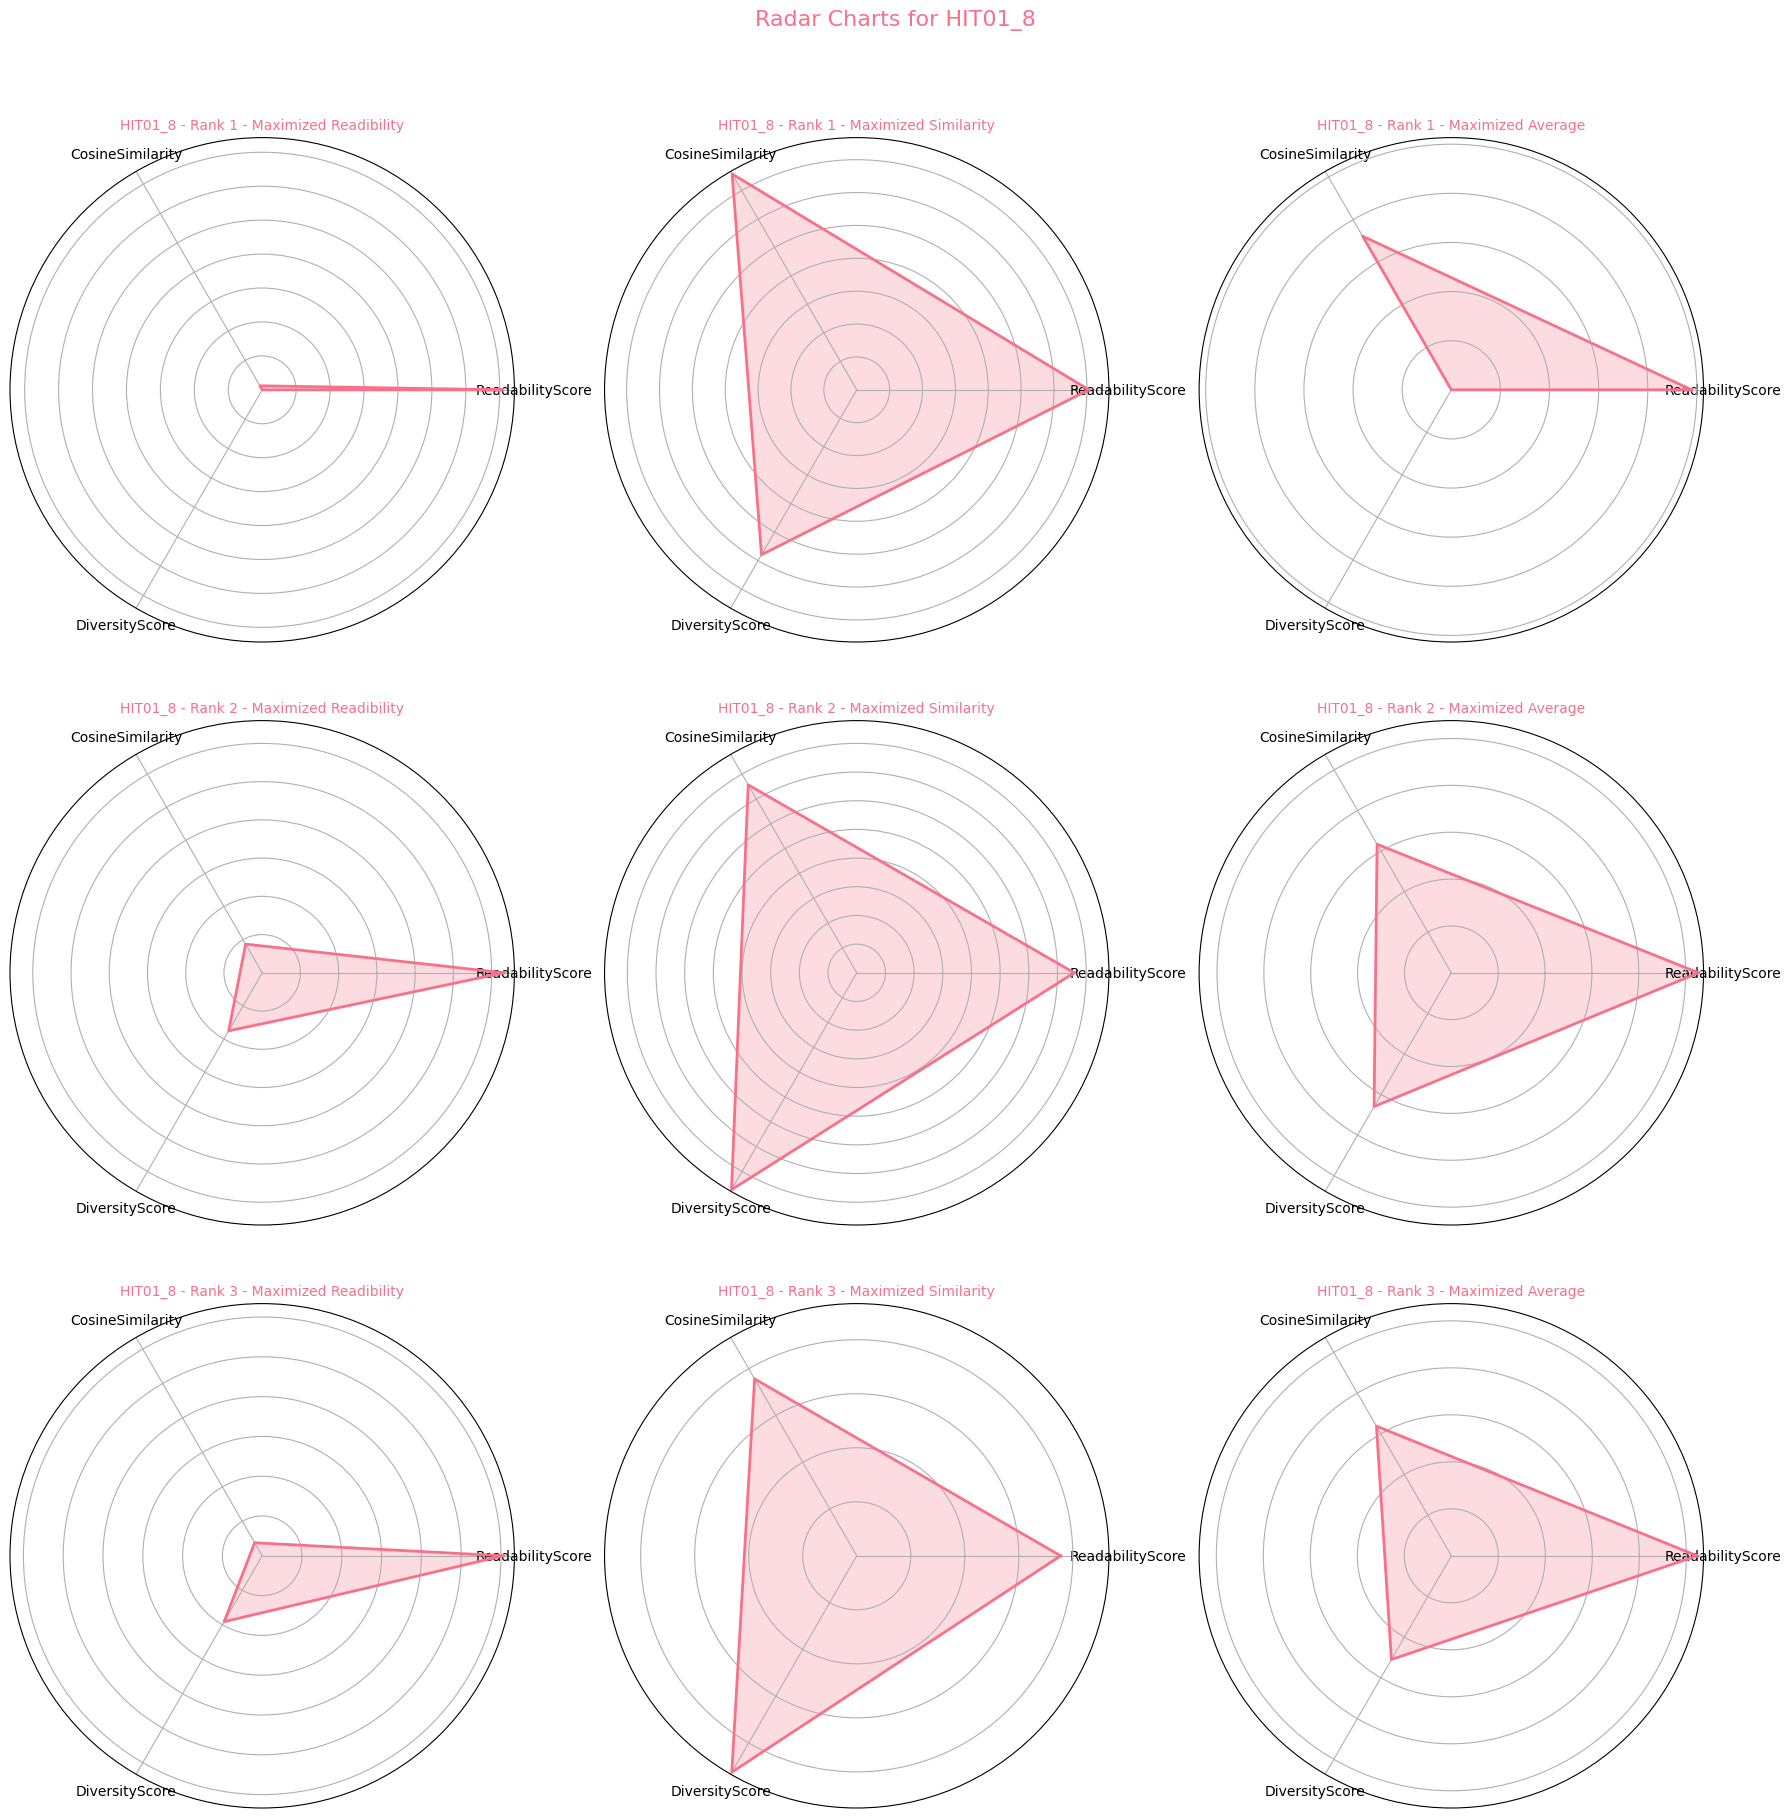

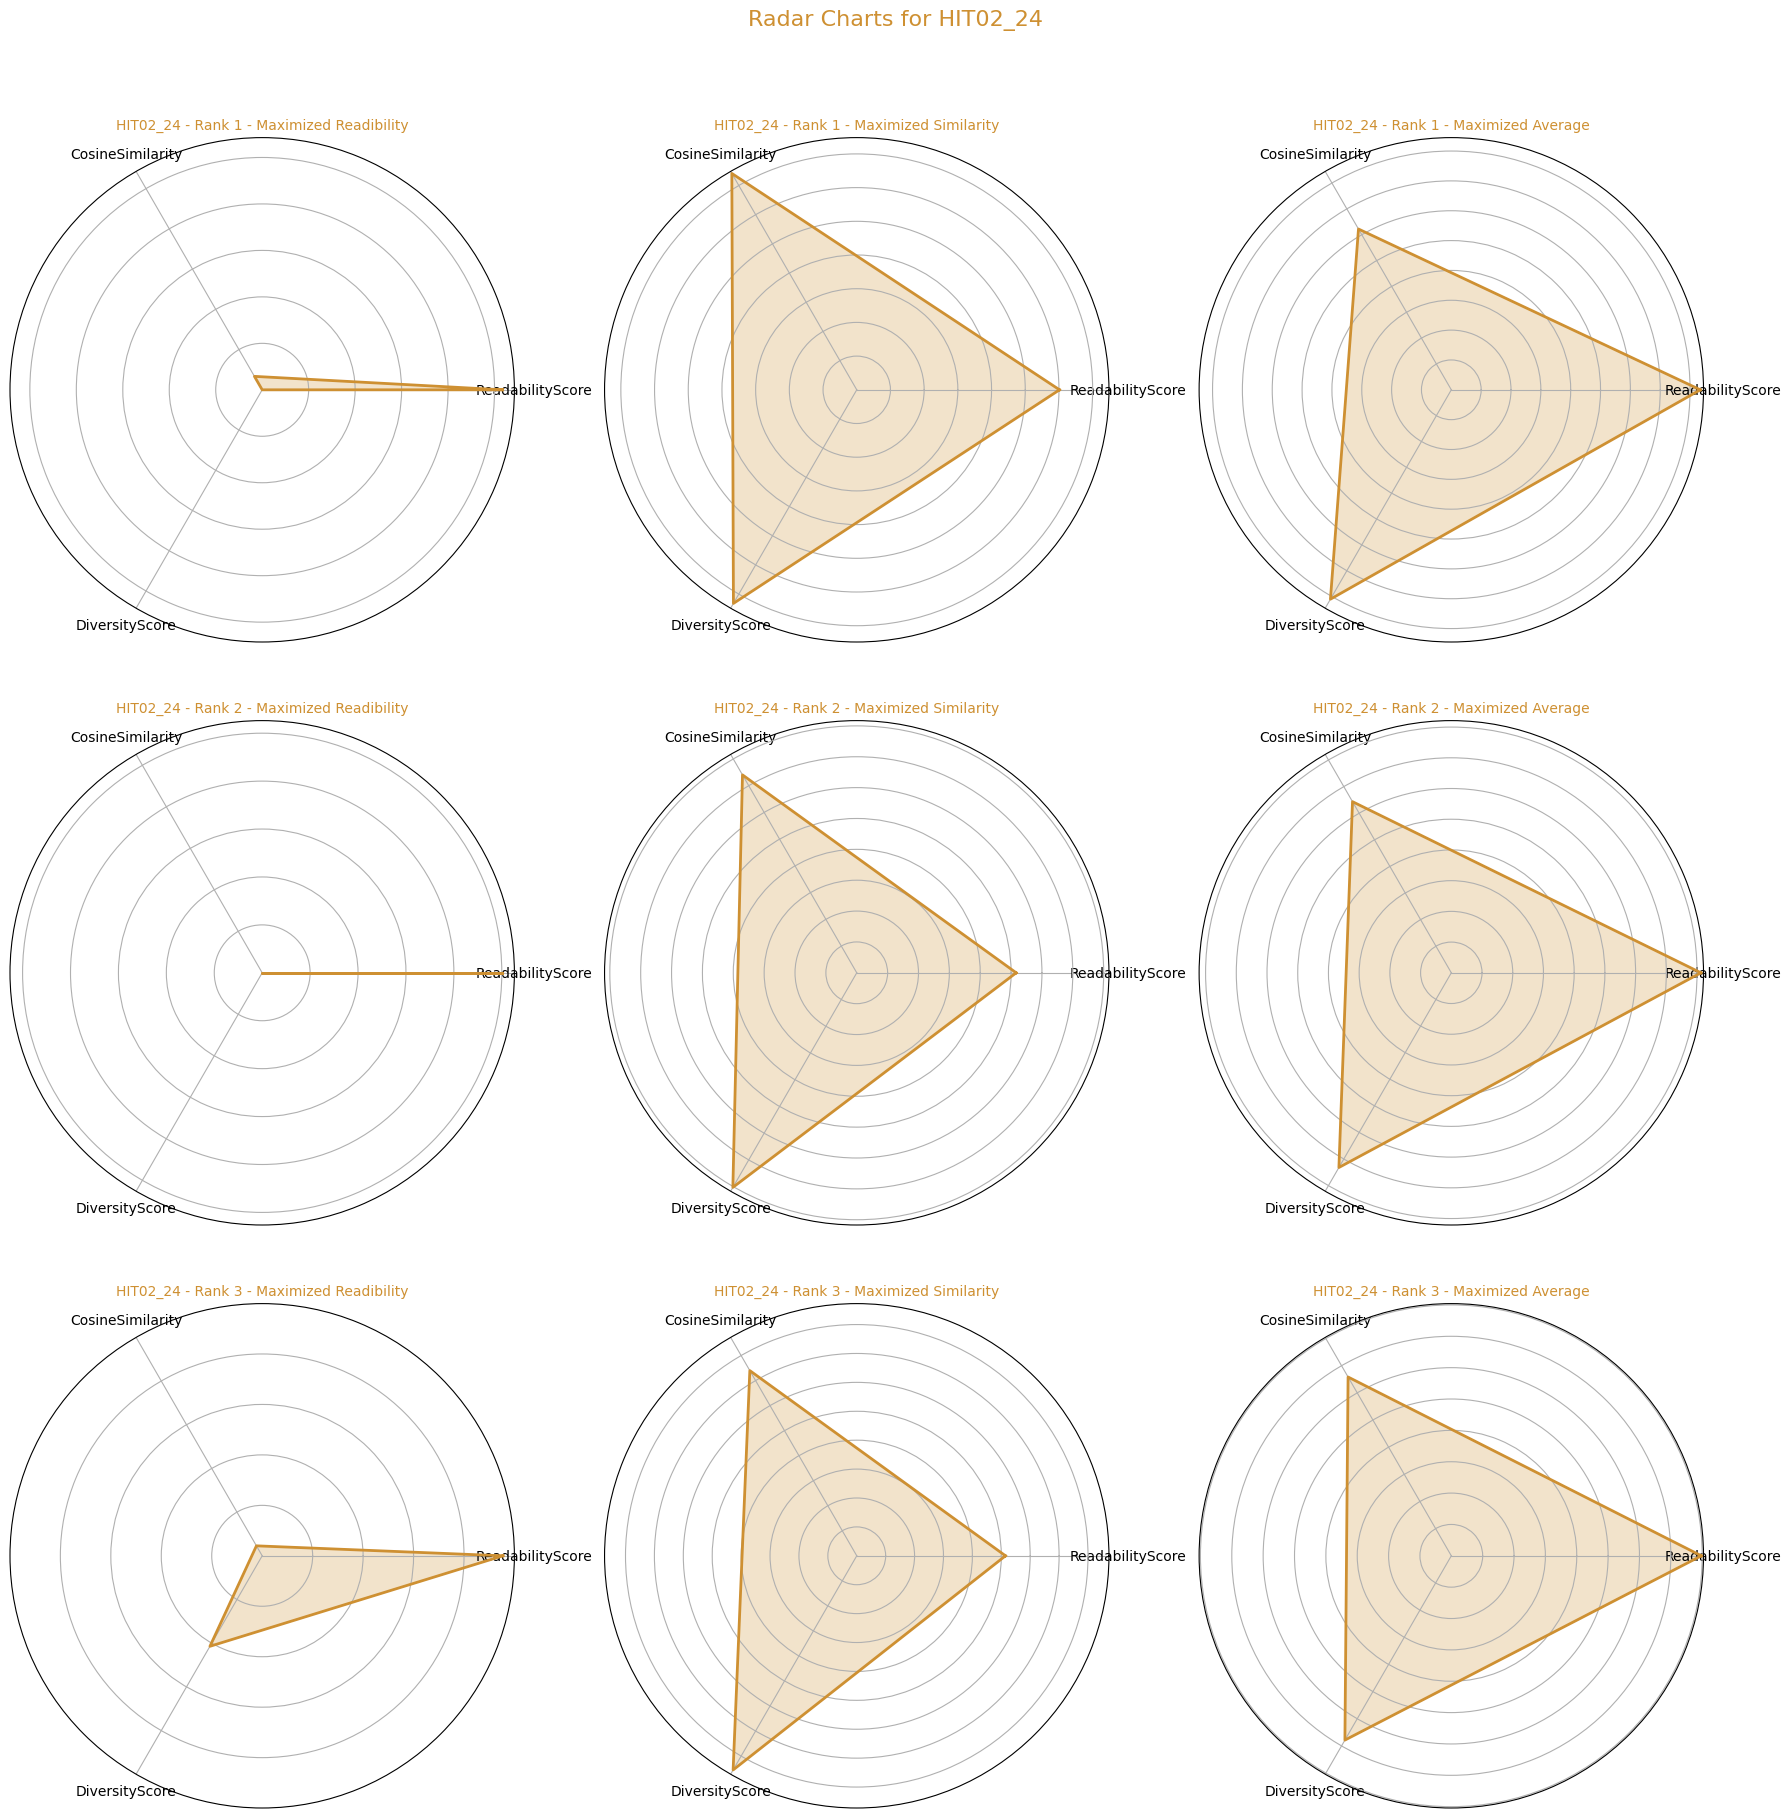

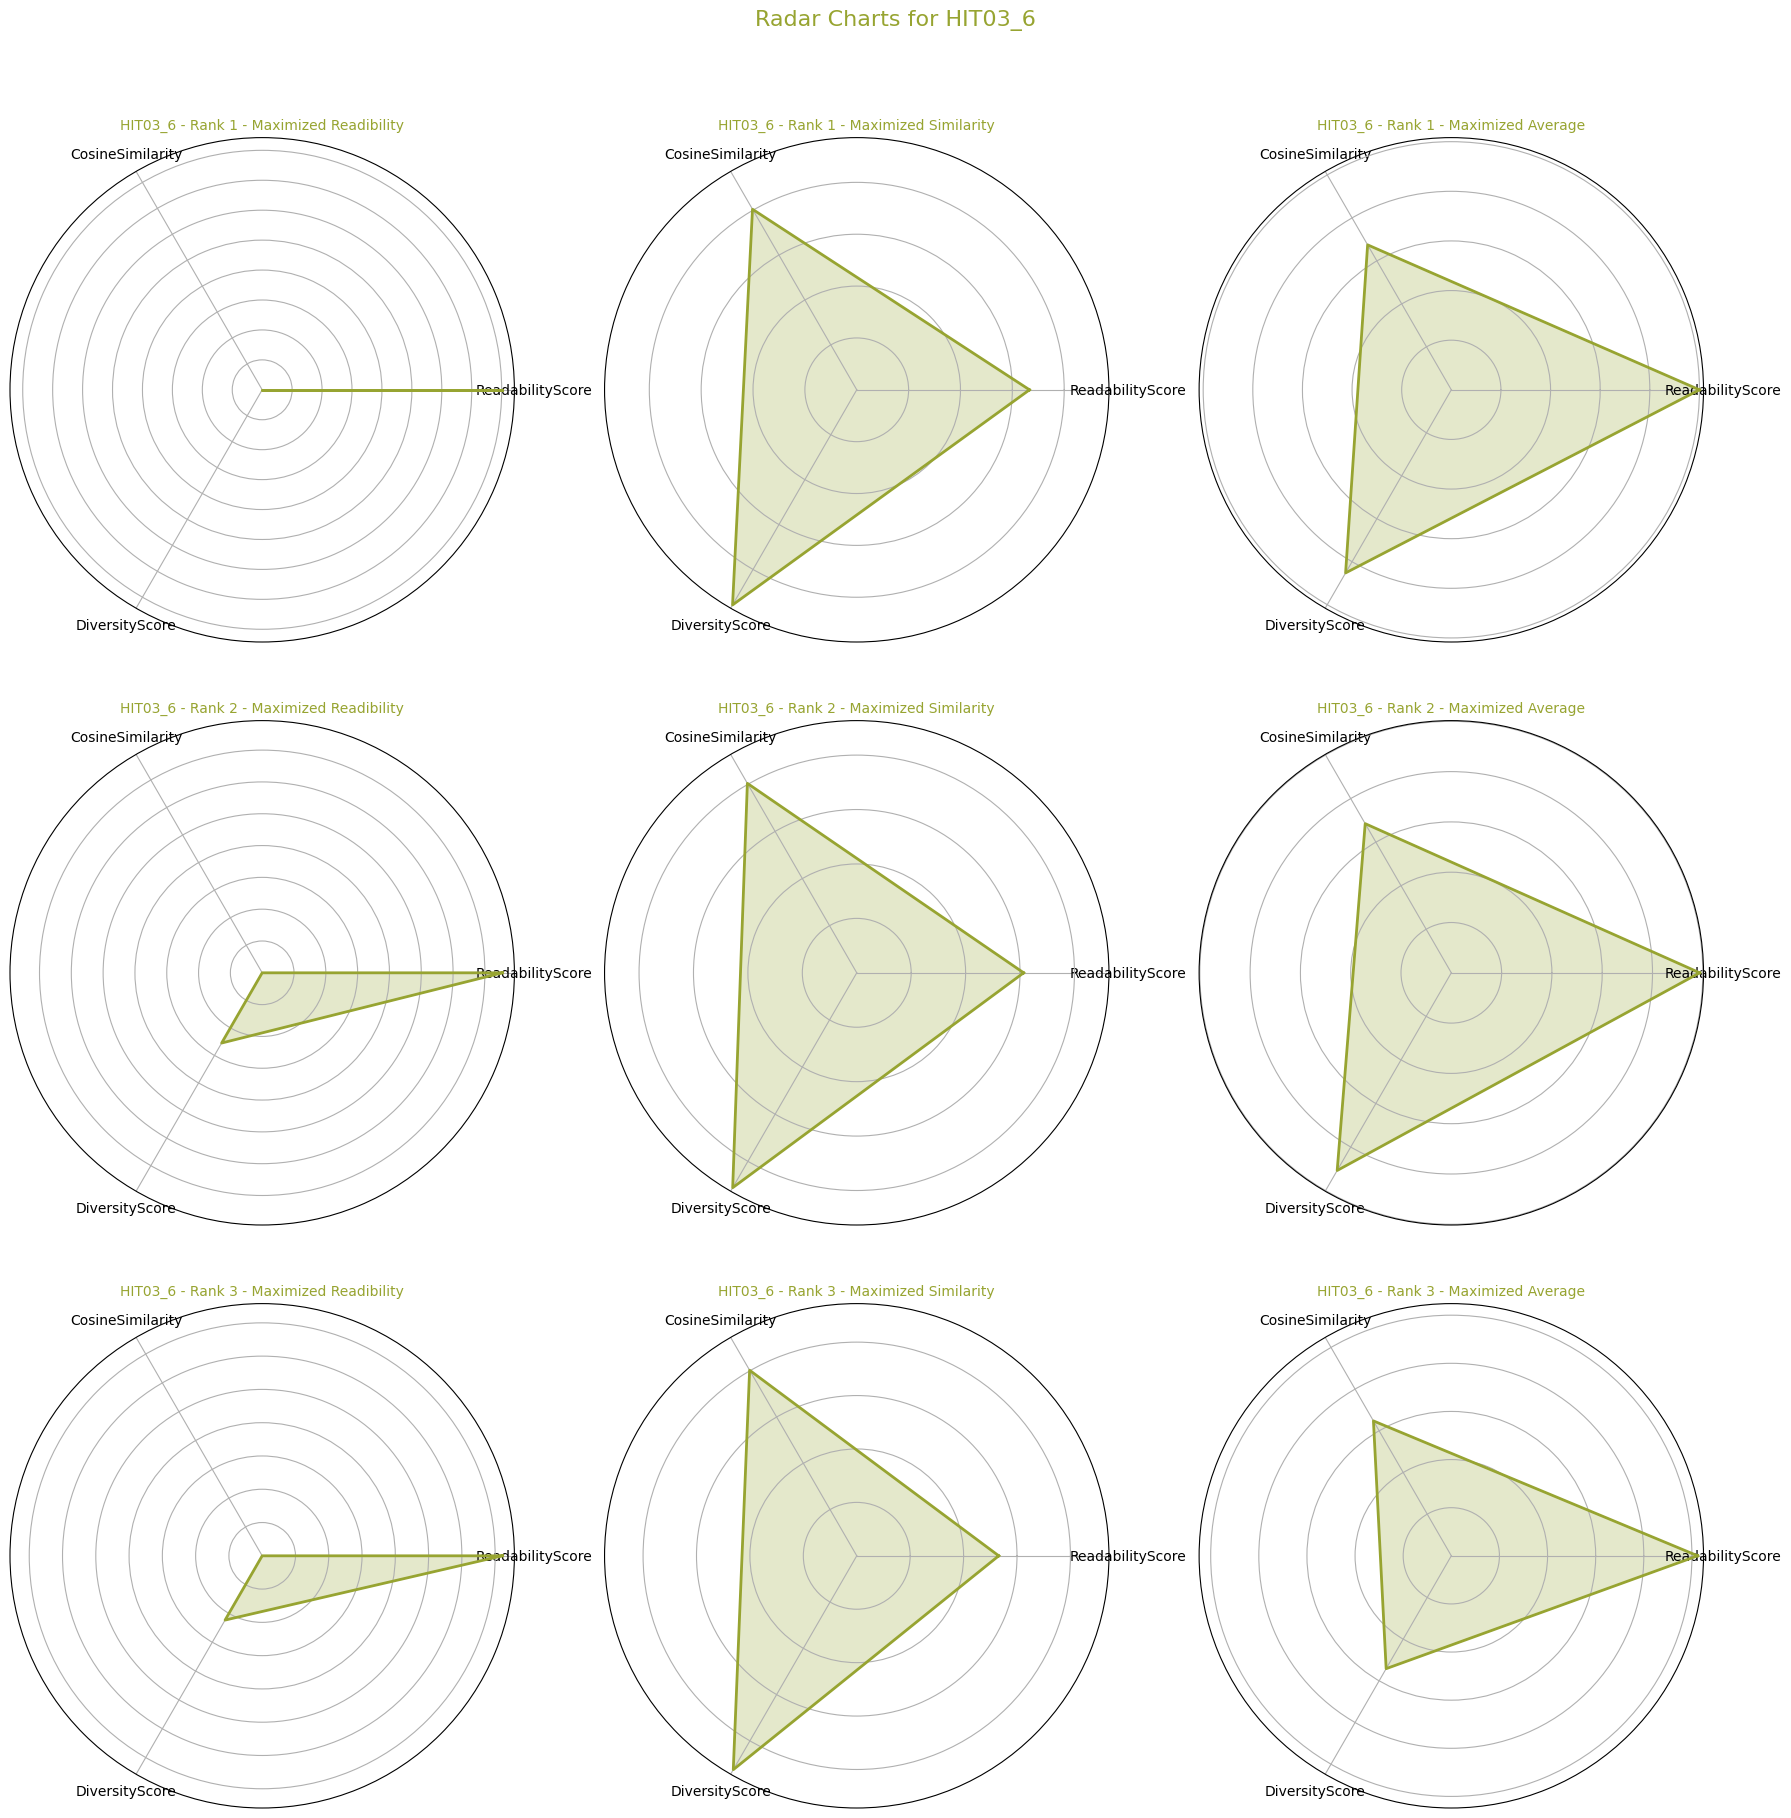

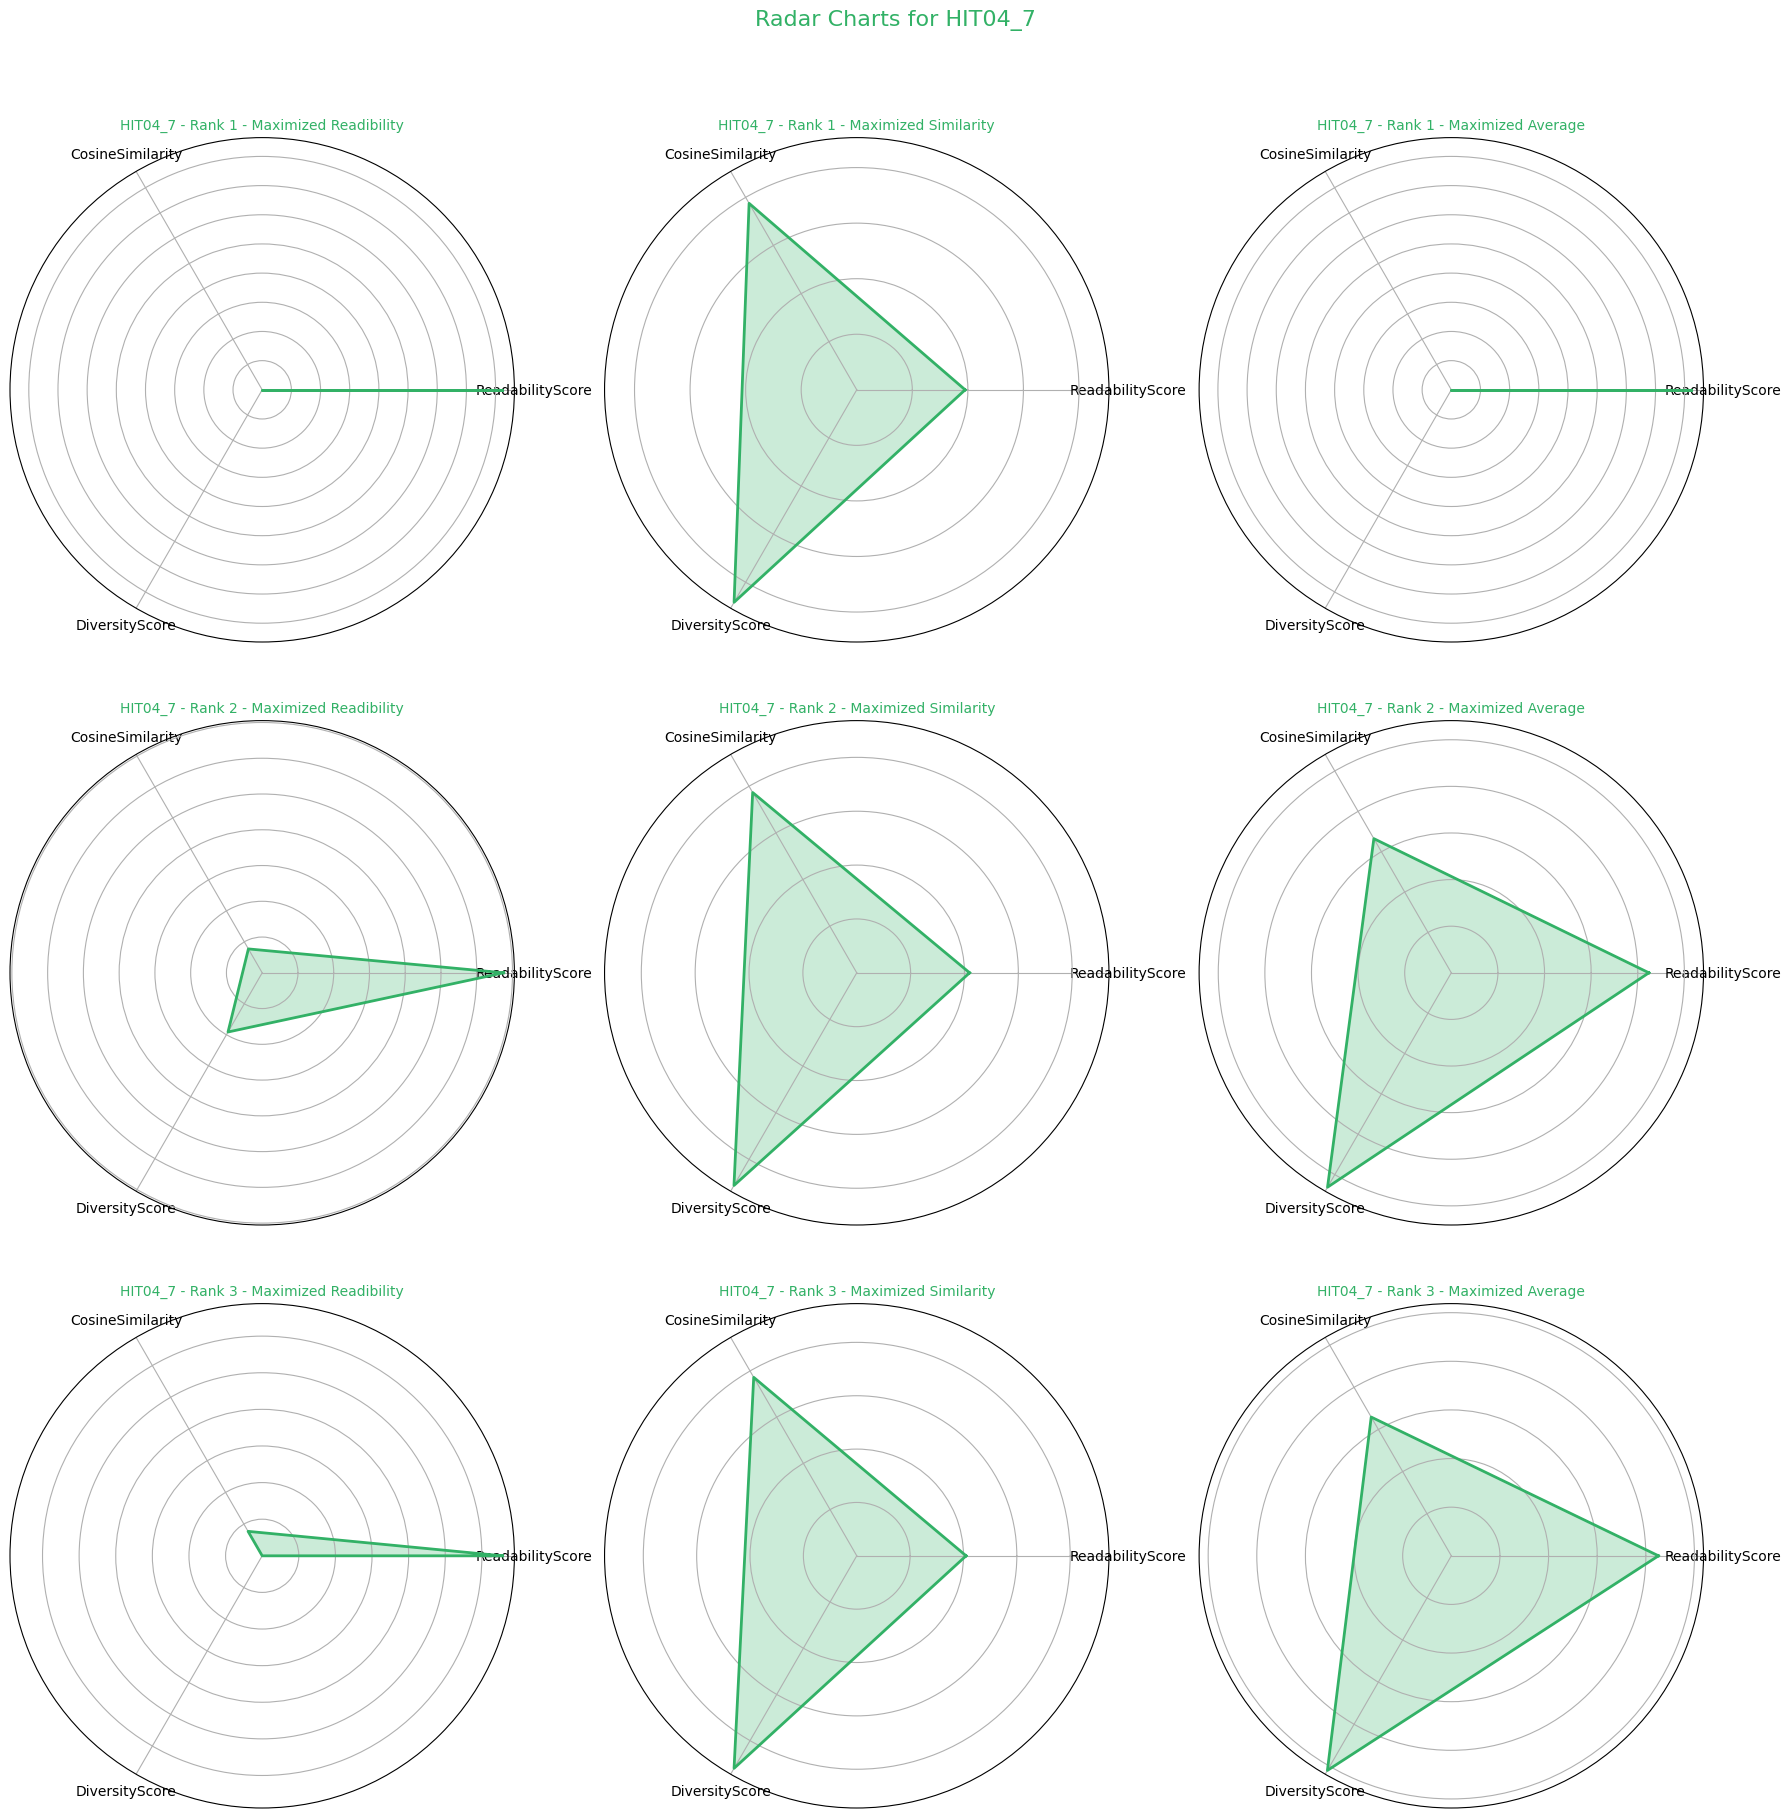

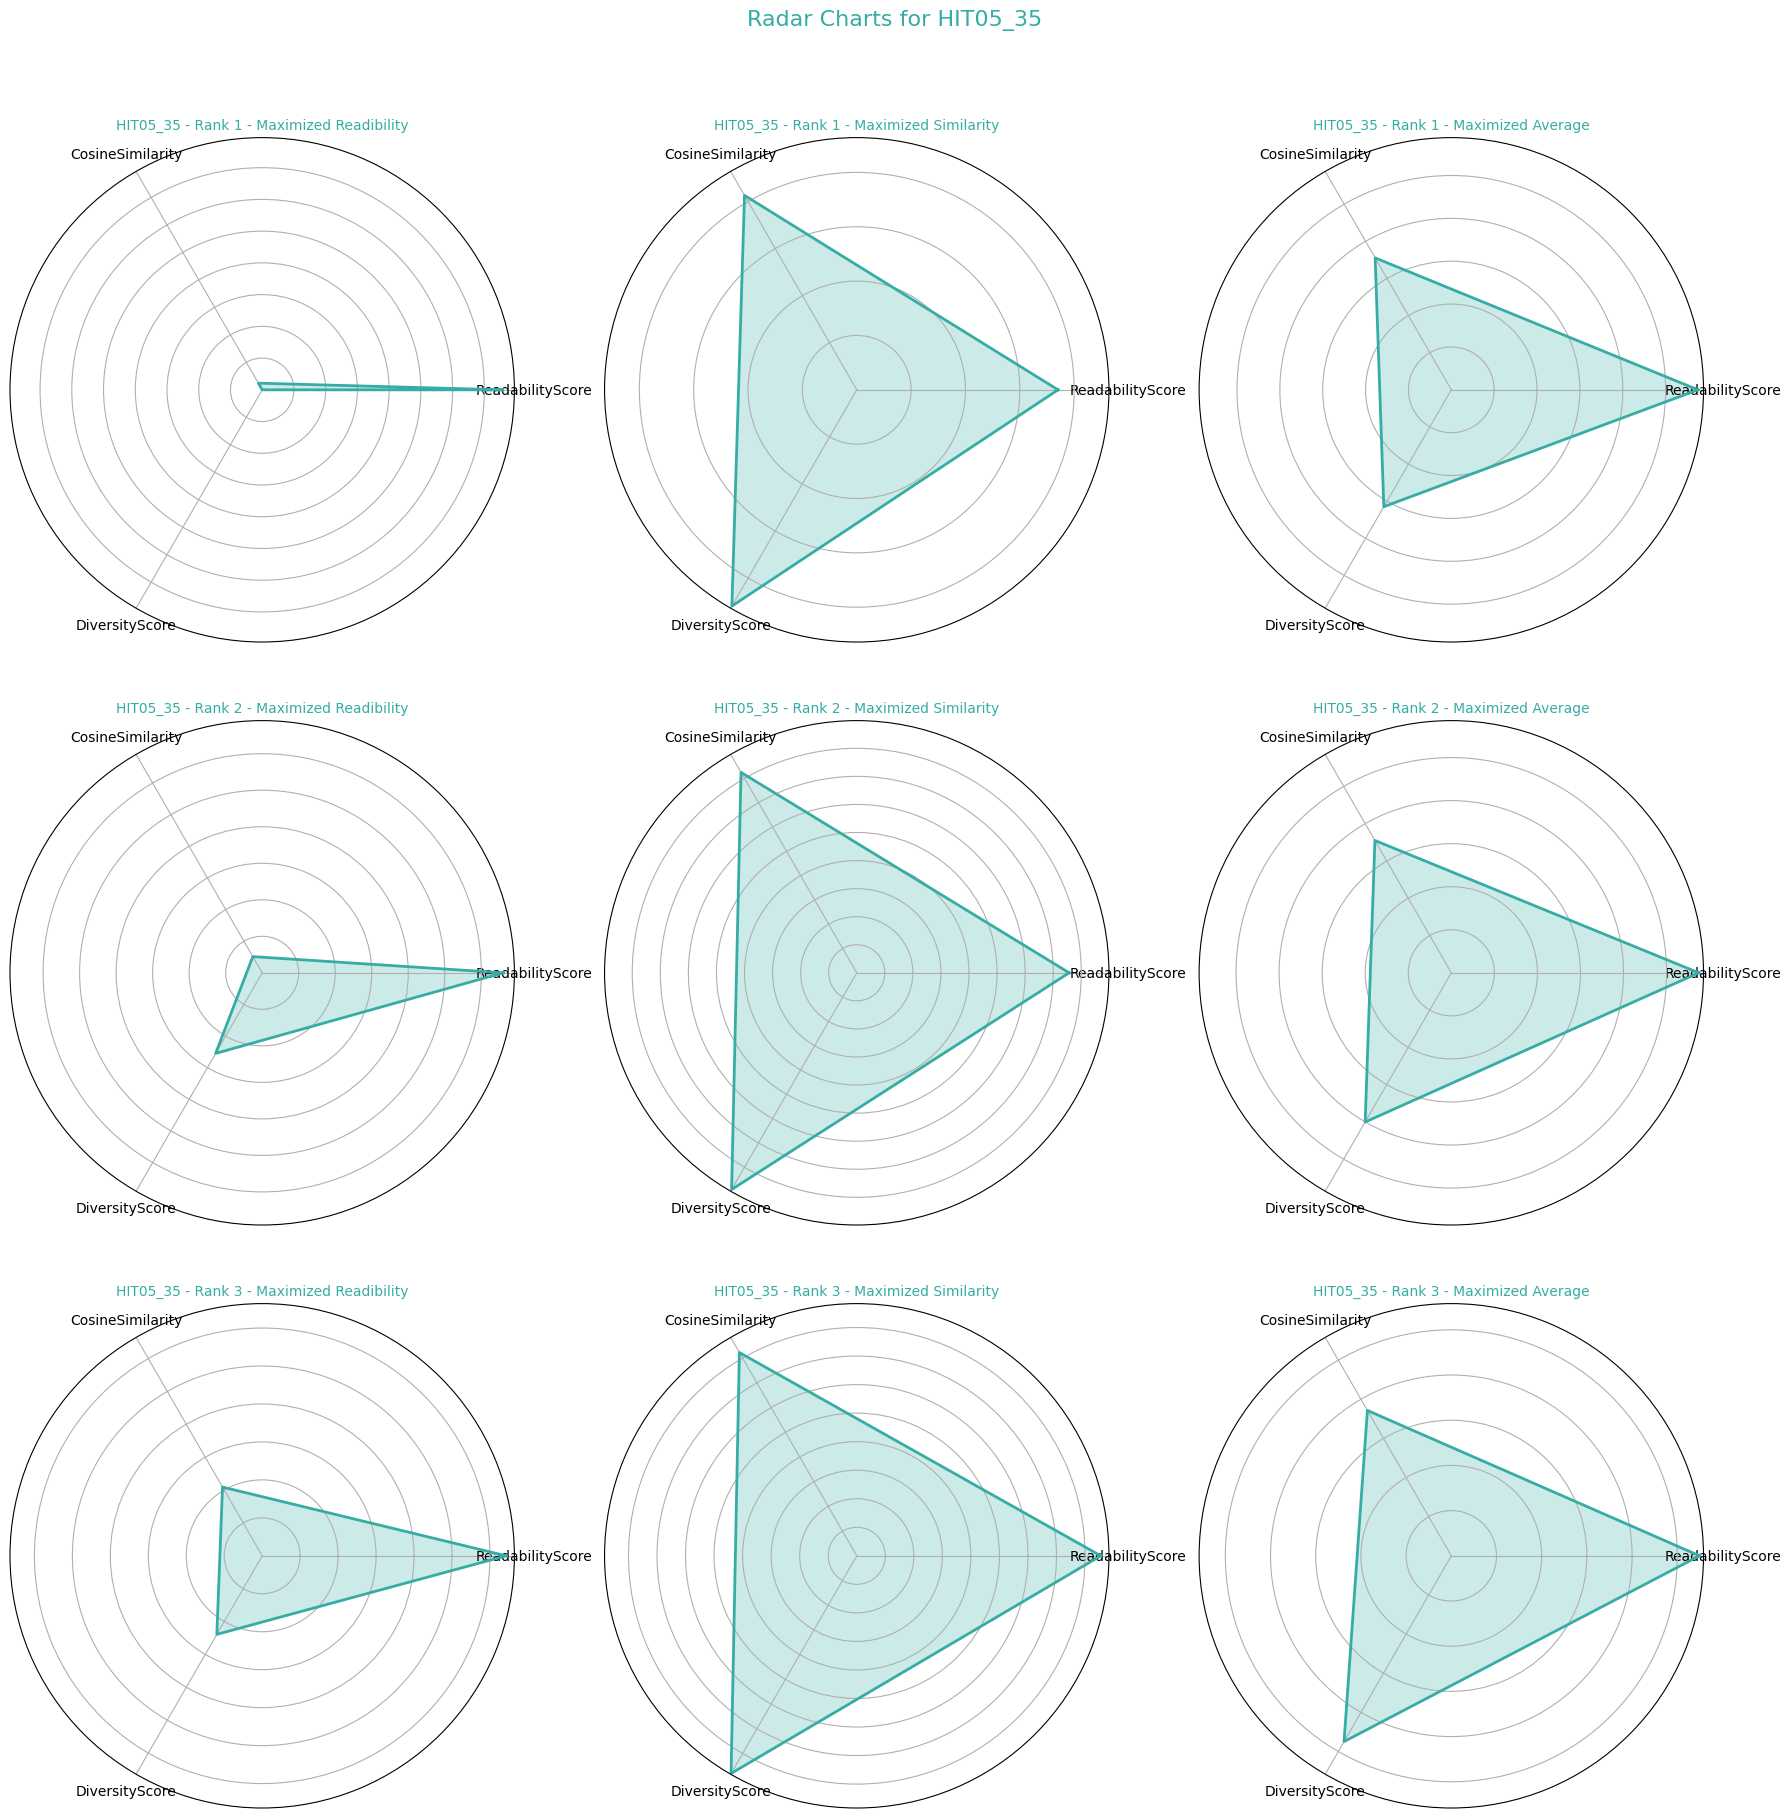

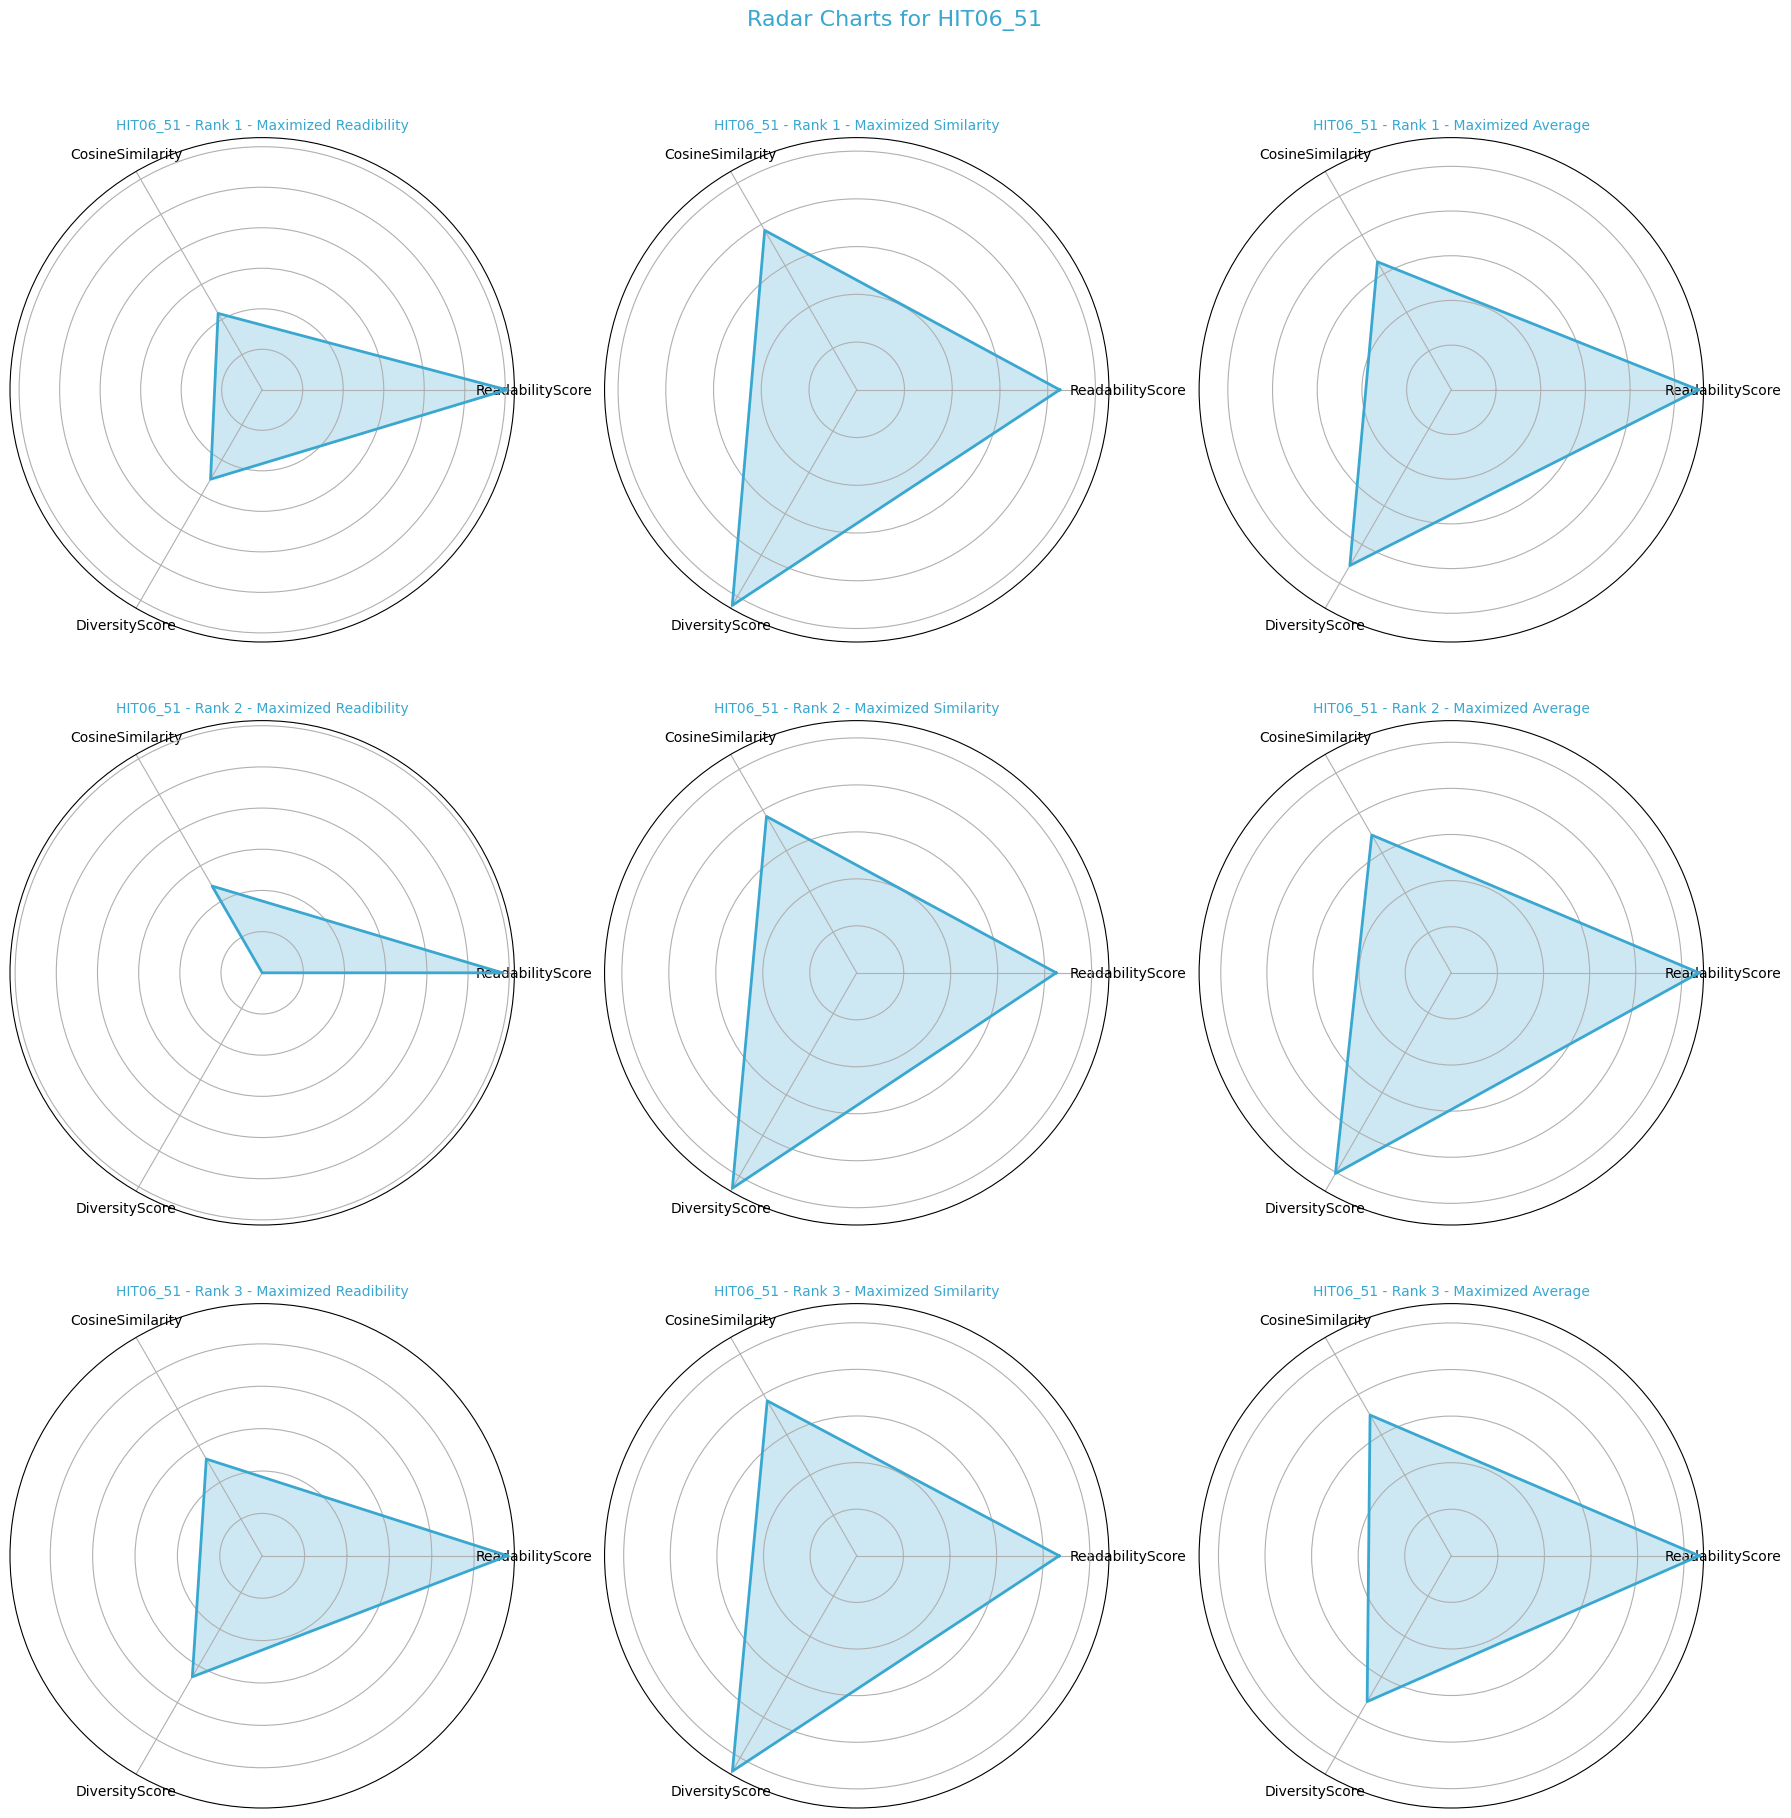

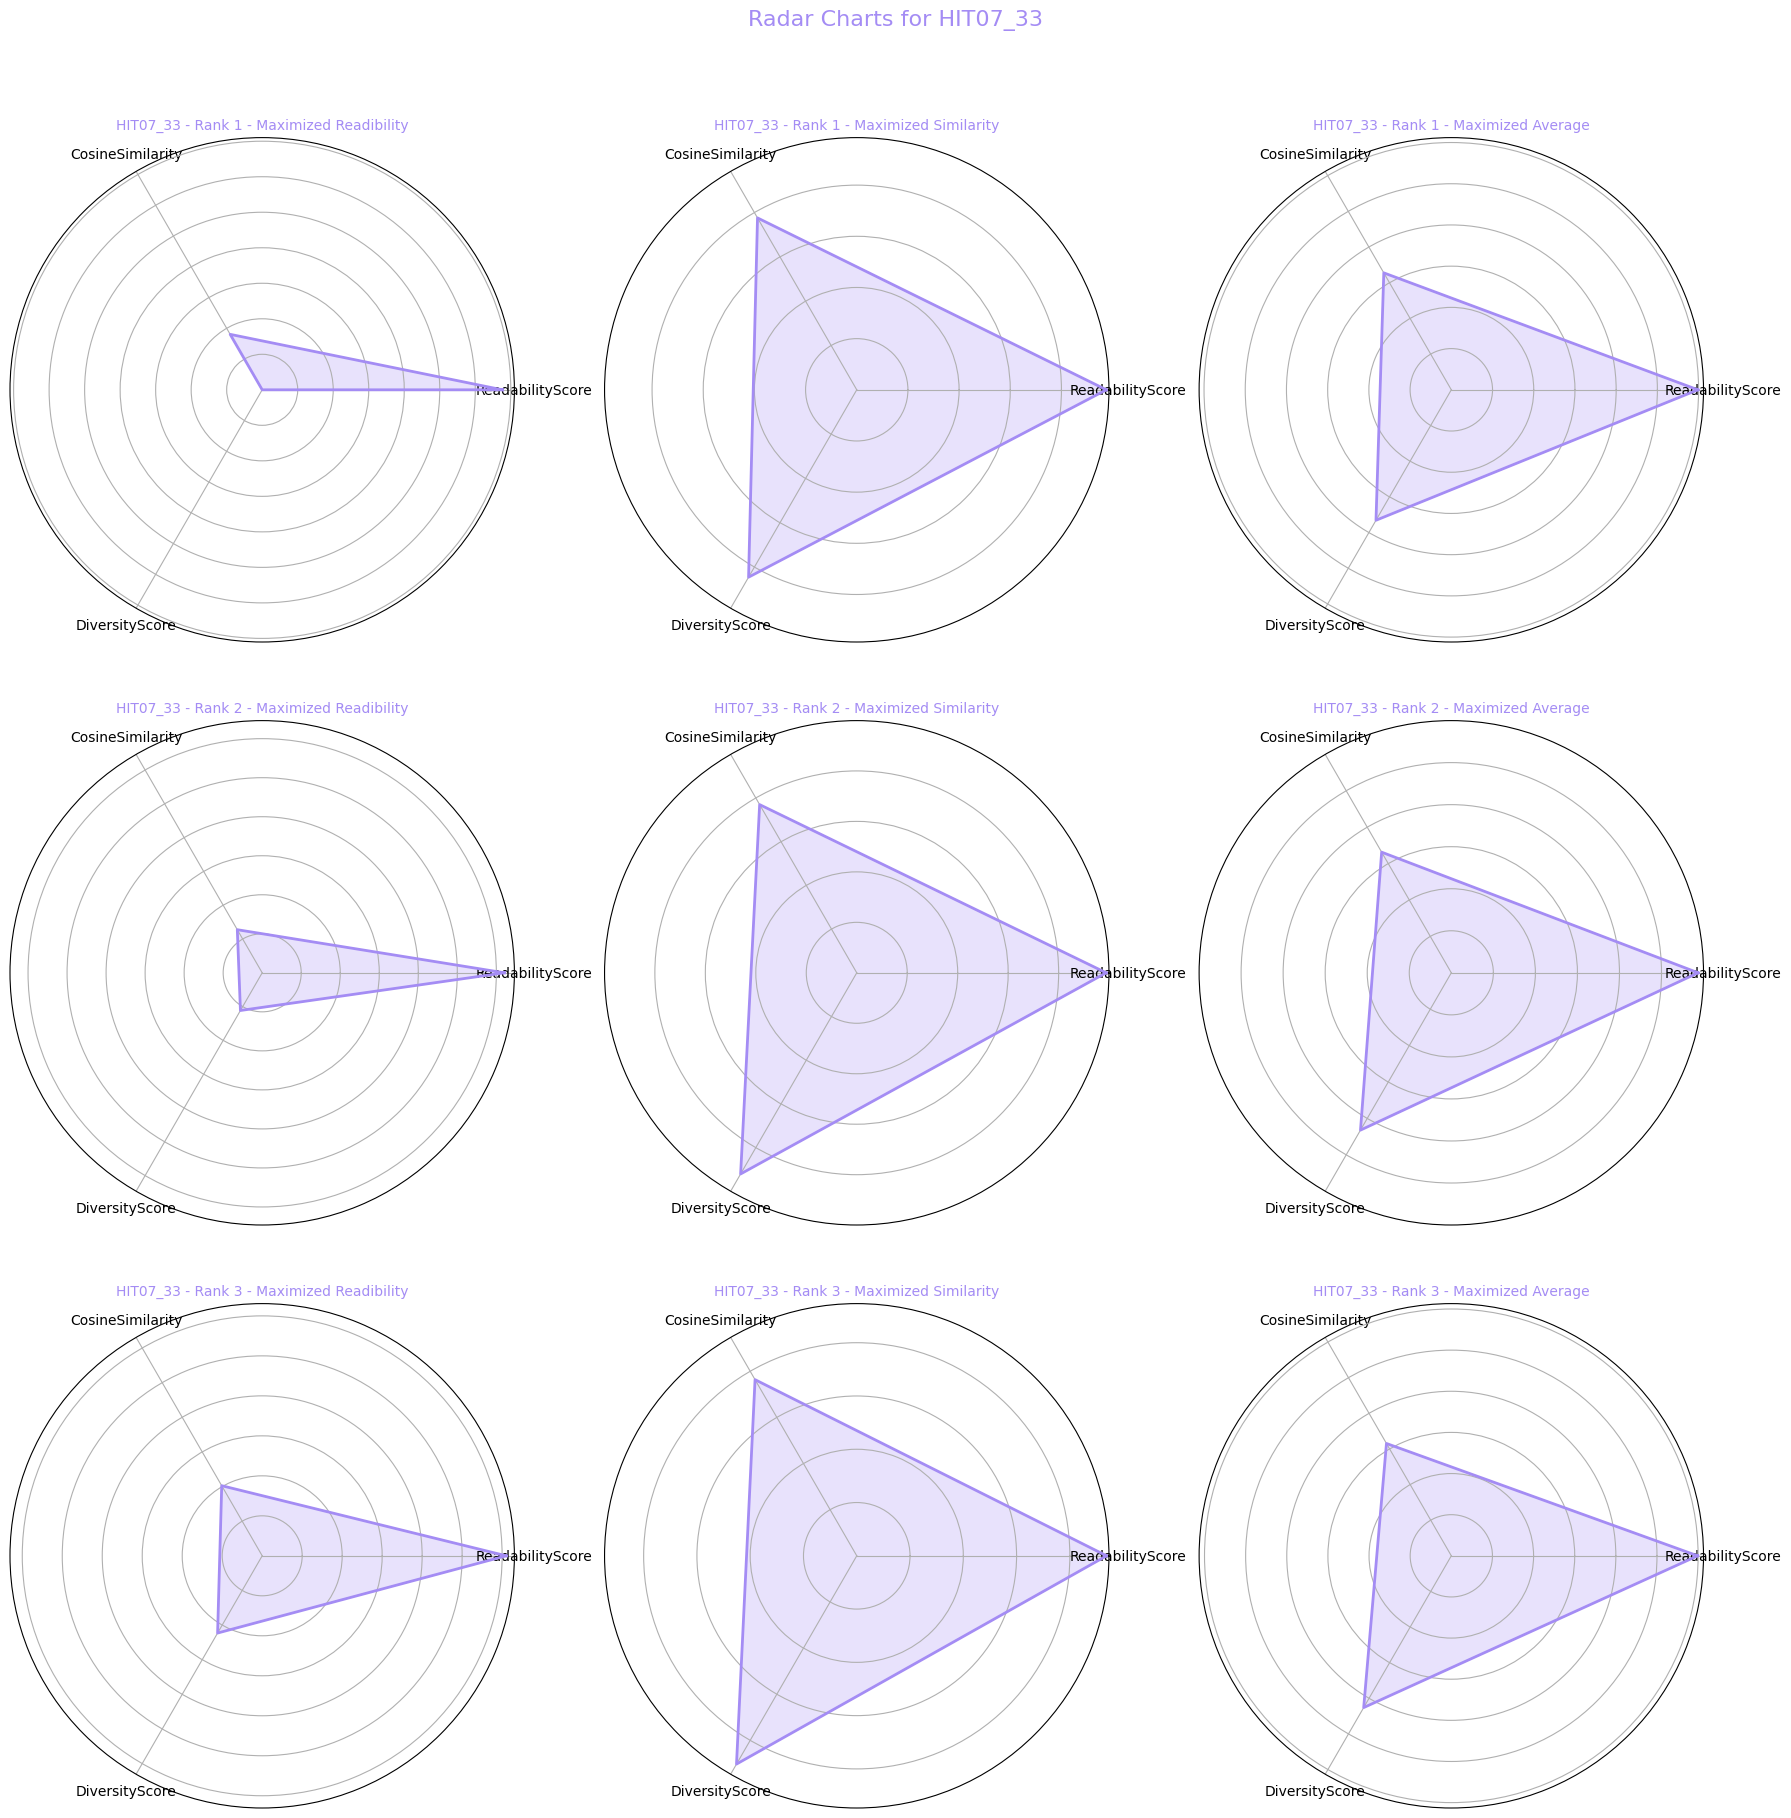

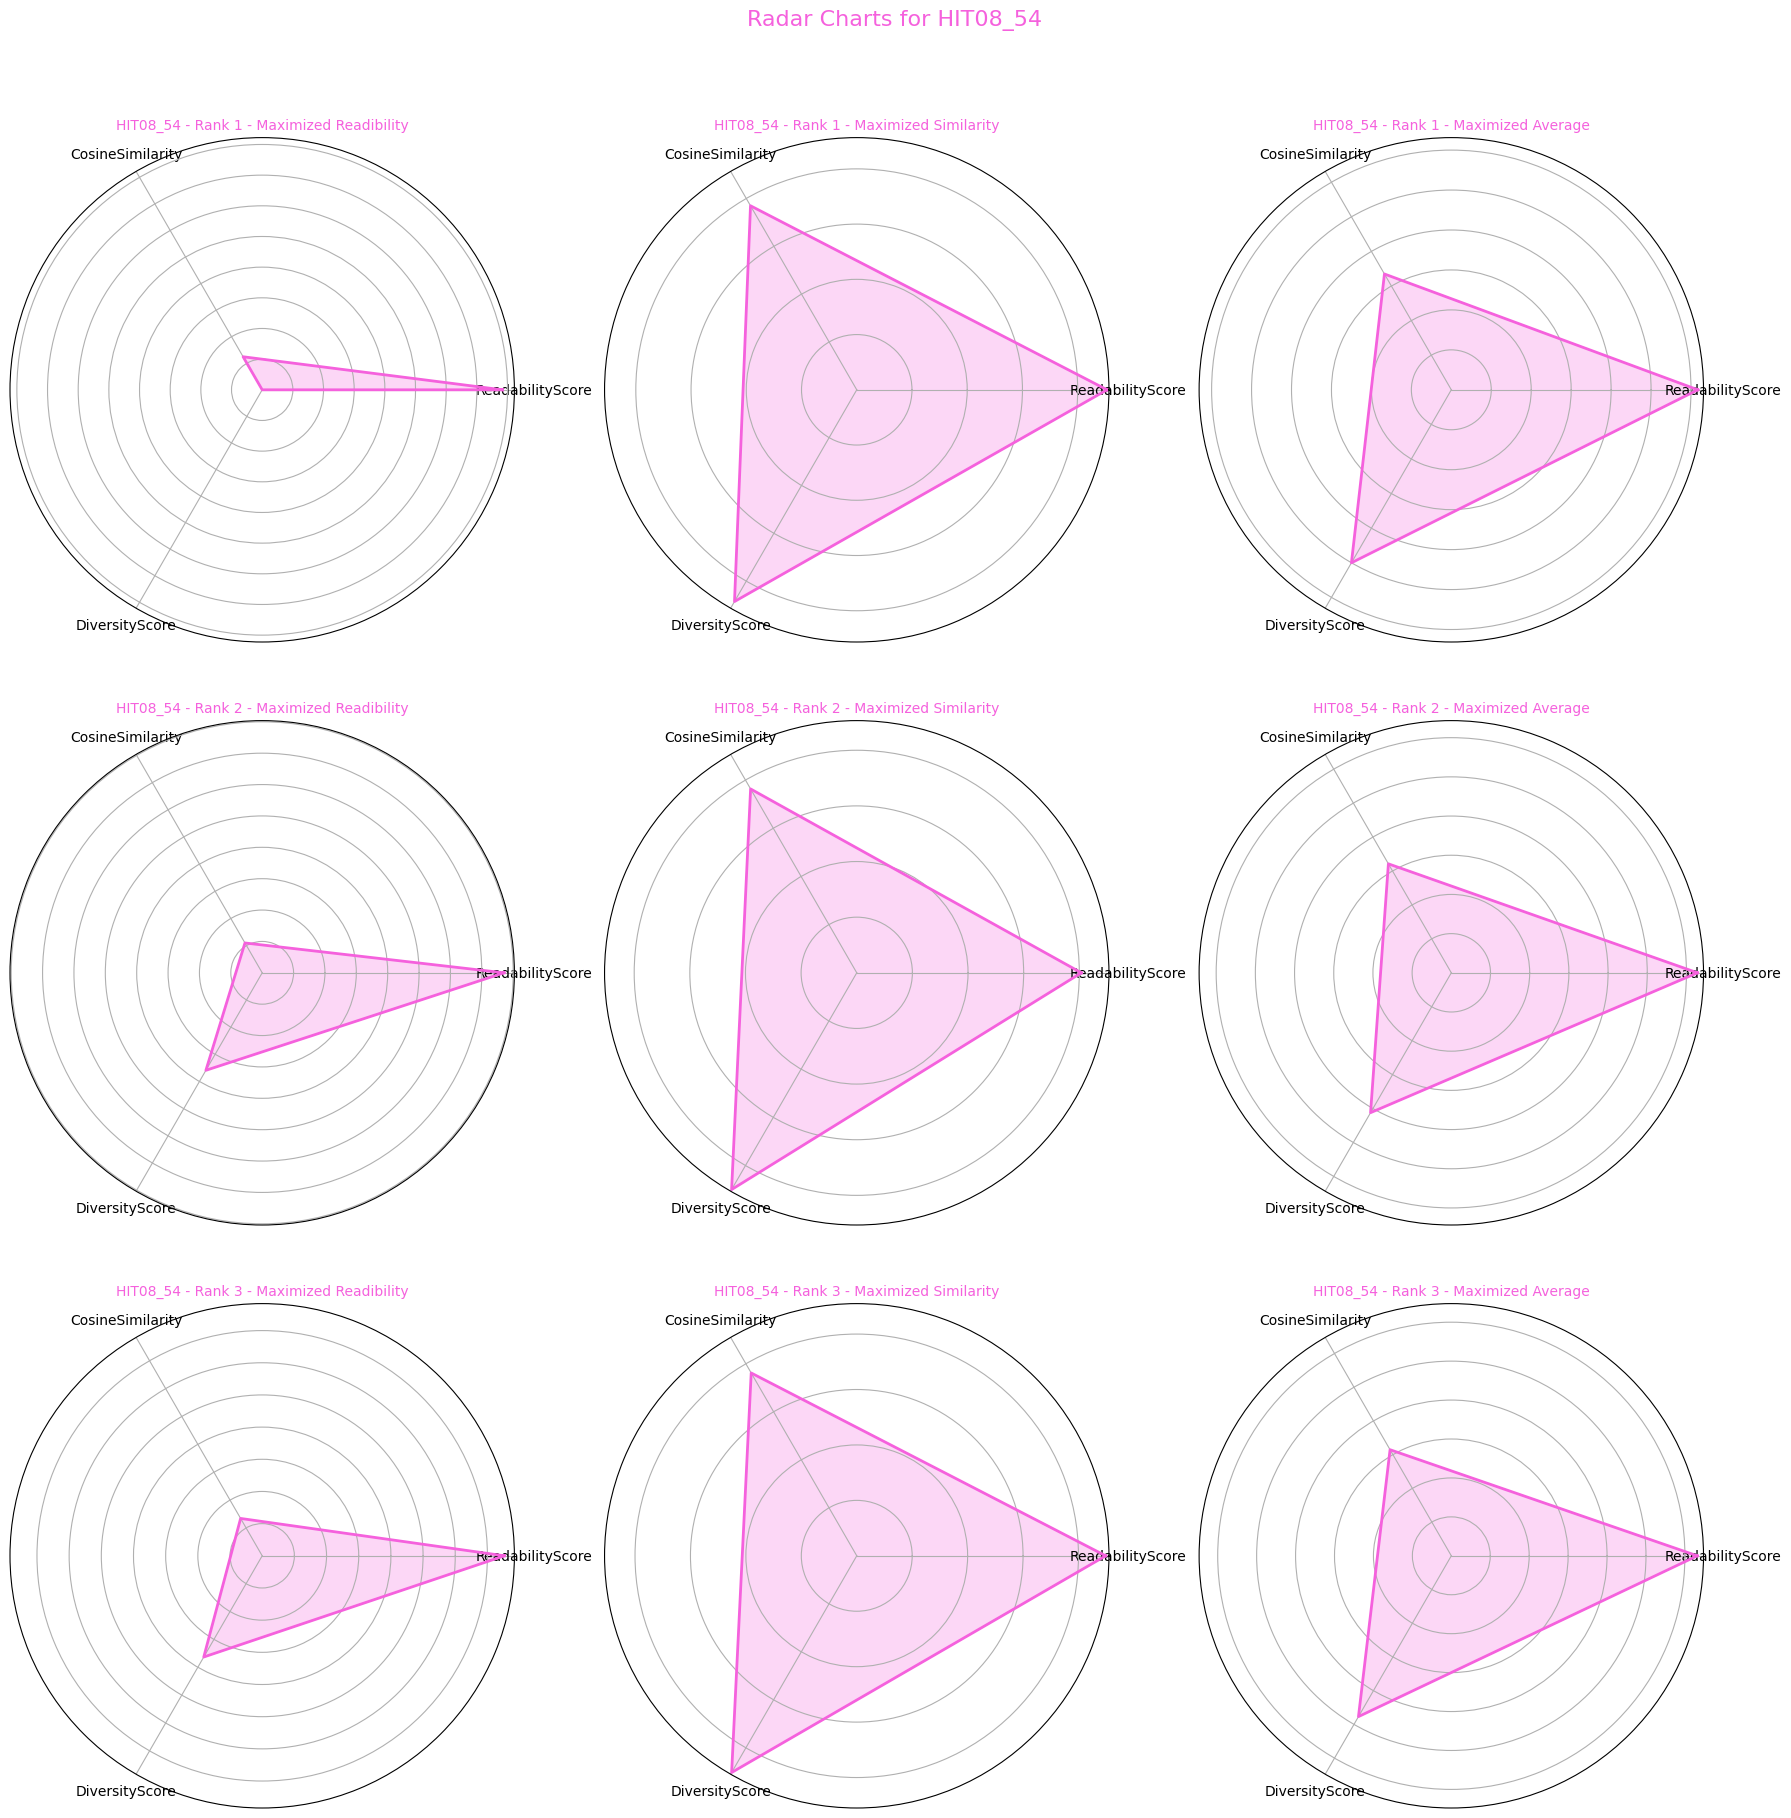

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Normalize function to scale each metric between 0 and 1
def normalize_series(series, min_value, max_value):
    return (series - min_value) / (max_value - min_value)

# Function to create radar chart for a single metric of a method
def create_radar_chart(ax, data, metrics, rank, method, method_color, title):
    # Number of variables (metrics)
    num_vars = len(metrics)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Normalize data for each metric
    normalized_data = []
    for metric in metrics:
        if metric == "CosineSimilarity":
            # No normalization needed for CosineSimilarity as it's between 0 and 1
            normalized_data.append(data[metric].mean())
        elif metric == "ReadabilityScore":
            # Normalize ReadabilityScore between 0 and 1
            normalized_data.append(data[metric].mean() / 100)
        elif metric == "DiversityScore":
            normalized_data.append(data[metric].mean() / max_entropy)

    normalized_data += normalized_data[:1]  # Repeat the first value to close the radar chart
    angles += angles[:1]

    # Create the radar chart
    ax.fill(angles, normalized_data, color=method_color, alpha=0.25)
    ax.plot(angles, normalized_data, color=method_color, linewidth=2)  # Plot the outline

    # Set the labels for each axis
    ax.set_yticklabels([])  # Hide radial ticks
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=10)

    # Set the title for the chart
    ax.set_title(f'{method} - Rank {rank} - {title}', size=10, color=method_color)

# Metrics to compare (excluding AverageScore)
metrics = ["ReadabilityScore", "CosineSimilarity", "DiversityScore"]

# Get a Seaborn color palette for the number of methods
color_palette = sns.color_palette("husl", len(failing_methods))

# Iterate over methods to create distinct plots for each method
for i, method in enumerate(failing_methods): 
    method_color = color_palette[i]  # Assign color based on the method index
    
    # Create a new figure for each method
    fig, axes = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    
    for rank in range(1, 4):  # Iterate over ranks 1, 2, and 3
        # Read the top ranked DataFrames for each metric
        readability_df = pd.read_csv(f"top_ranked_dfs/top_readability_{method}_rank_{rank}.csv")
        average_score_df = pd.read_csv(f"top_ranked_dfs/top_average_score_{method}_rank_{rank}.csv")
        cosine_similarity_df = pd.read_csv(f"top_ranked_dfs/top_cosine_similarity_{method}_rank_{rank}.csv")
        
        # Create radar charts for each metric for the current method and rank
        create_radar_chart(axes[rank - 1, 0], readability_df, metrics, rank, method, method_color, "Maximized Readibility")  # Readability
        create_radar_chart(axes[rank - 1, 1], cosine_similarity_df, metrics, rank, method, method_color, "Maximized Similarity")  # CosineSimilarity
        create_radar_chart(axes[rank - 1, 2], average_score_df, metrics, rank, method, method_color, "Maximized Average")  # AverageScore

    # Adjust layout and set the title for the entire figure
    fig.suptitle(f"Radar Charts for {method}", size=16, color=method_color, y=1.02)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


In [121]:
top_average_score = {}
top_readability = {}
top_cosine_similarity = {}

read_read_score = []
read_cosine_score = []
read_diversity_score = []

cosine_read_score = []
cosine_cosine_score = []
cosine_diversity_score = []

average_read_score = []
average_cosine_score = []
average_diversity_score = []

for method in failing_methods:
    top_average_score[method] = pd.read_csv(f"top_ranked_dfs/top_average_score_{method}_rank_1.csv")
    top_readability[method] = pd.read_csv(f"top_ranked_dfs/top_readability_{method}_rank_1.csv")
    top_cosine_similarity[method] = pd.read_csv(f"top_ranked_dfs/top_cosine_similarity_{method}_rank_1.csv")

    print(f"Method: {method}")
    print("Maximized readibility score")
    print(f"Readability Score: {top_readability[method]['ReadabilityScore'].mean()}")
    read_read_score.append(top_readability[method]['ReadabilityScore'].mean())
    print(f"Cosine Similarity Score: {top_readability[method]['CosineSimilarity'].mean()}")
    read_cosine_score.append(top_readability[method]['CosineSimilarity'].mean())
    print(f"Diversity Score: {top_readability[method]['DiversityScore'].mean()}")
    read_diversity_score.append(top_readability[method]['DiversityScore'].mean())
    print("Maximized cosine similarity score")
    print(f"Readability Score: {top_cosine_similarity[method]['ReadabilityScore'].mean()}")
    cosine_read_score.append(top_cosine_similarity[method]['ReadabilityScore'].mean())
    print(f"Cosine Similarity Score: {top_cosine_similarity[method]['CosineSimilarity'].mean()}")
    cosine_cosine_score.append(top_cosine_similarity[method]['CosineSimilarity'].mean())
    print(f"Diversity Score: {top_cosine_similarity[method]['DiversityScore'].mean()}")
    cosine_diversity_score.append(top_cosine_similarity[method]['DiversityScore'].mean())
    print("Maximized average across readibility and cosine similarity score")
    print(f"Readability Score: {top_average_score[method]['ReadabilityScore'].mean()}")
    average_read_score.append(top_average_score[method]['ReadabilityScore'].mean())
    print(f"Cosine Similarity Score: {top_average_score[method]['CosineSimilarity'].mean()}")
    average_cosine_score.append(top_average_score[method]['CosineSimilarity'].mean())
    print(f"Diversity Score: {top_average_score[method]['DiversityScore'].mean()}")
    average_diversity_score.append(top_average_score[method]['DiversityScore'].mean())
    print("\n")

print("Maximized Readibility Score")
print(f"Average Readibility Score: {sum(read_read_score) / len(read_read_score)}")
print(f"Average Cosine Similarity Score: {sum(read_cosine_score) / len(read_cosine_score)}")
print(f"Average Diversity Score: {sum(read_diversity_score) / len(read_diversity_score)}")
print("Maximized Similarity Score")
print(f"Average Readibility Score: {sum(cosine_read_score) / len(cosine_read_score)}")
print(f"Average Cosine Similarity Score: {sum(cosine_cosine_score) / len(cosine_cosine_score)}")
print(f"Average Diversity Score: {sum(cosine_diversity_score) / len(cosine_diversity_score)}")
print("Maximized Average Score")
print(f"Average Readibility Score: {sum(average_read_score) / len(average_read_score)}")
print(f"Average Cosine Similarity Score: {sum(average_cosine_score) / len(average_cosine_score)}")
print(f"Average Diversity Score: {sum(average_diversity_score) / len(average_diversity_score)}")
print("\n")

print(f'Max readibility score: {max(read_read_score + cosine_read_score + average_read_score)}')
print(f'Max cosine similarity score: {max(read_cosine_score + cosine_cosine_score + average_cosine_score)}')
print(f'Max diversity score: {max(read_diversity_score + cosine_diversity_score + average_diversity_score)}')




Method: HIT01_8
Maximized readibility score
Readability Score: 141.565
Cosine Similarity Score: 0.027420424855354
Diversity Score: 0.0
Maximized cosine similarity score
Readability Score: 70.61410714285716
Cosine Similarity Score: 0.7582398722535449
Diversity Score: 18.18947501009619
Maximized average across readibility and cosine similarity score
Readability Score: 97.79659090909092
Cosine Similarity Score: 0.7225090546487353
Diversity Score: 0.0


Method: HIT02_24
Maximized readibility score
Readability Score: 103.37909090909092
Cosine Similarity Score: 0.066815310478106
Diversity Score: 0.0
Maximized cosine similarity score
Readability Score: 60.166726874657925
Cosine Similarity Score: 0.7413702320275876
Diversity Score: 22.972078920281582
Maximized average across readibility and cosine similarity score
Readability Score: 83.43923349056605
Cosine Similarity Score: 0.6220080099001517
Diversity Score: 25.42501142157966


Method: HIT03_6
Maximized readibility score
Readability Score: 1

In [111]:
for method in failing_methods:
    
    max_diversity_score = 0
    similarity = 0
    readability = 0

    for rank in range(1, 4):
        df = pd.read_csv(f"top_ranked_dfs/top_cosine_similarity_{method}_rank_{rank}.csv")
        diversity_score = df["DiversityScore"].mean()
        if diversity_score > max_diversity_score:
            max_diversity_score = diversity_score
            similarity = df["CosineSimilarity"].mean()
            readability = df["ReadabilityScore"].mean()

    print(f"Method: {method}")
    print("Max diversity for maximized cosine similarity score")
    print(f"Readability Score: {readability}")
    print(f"Cosine Similarity Score: {similarity}")
    print(f"Diversity Score: {max_diversity_score}")
    print("\n")

Method: HIT01_8
Max diversity for maximized cosine similarity score
Readability Score: 75.48339666090963
Cosine Similarity Score: 0.7565216456124266
Diversity Score: 29.039818205809052


Method: HIT02_24
Max diversity for maximized cosine similarity score
Readability Score: 51.45744444444447
Cosine Similarity Score: 0.739795442874108
Diversity Score: 26.84889451733241


Method: HIT03_6
Max diversity for maximized cosine similarity score
Readability Score: 66.62214285714289
Cosine Similarity Score: 0.8040749564613417
Diversity Score: 30.068867611354385


Method: HIT04_7
Max diversity for maximized cosine similarity score
Readability Score: 40.99202898550726
Cosine Similarity Score: 0.7724030618434622
Diversity Score: 28.868867611354386


Method: HIT05_35
Max diversity for maximized cosine similarity score
Readability Score: 74.06176470588237
Cosine Similarity Score: 0.8261126390287721
Diversity Score: 28.84889451733241


Method: HIT06_51
Max diversity for maximized cosine similarity sco

In [117]:
overall_readability_num_explanations_avg = []
overall_cosine_similarity_num_explanations_avg = []
overall_average_score_num_explanations_avg = []

for method in failing_methods:
    readibiliy_num_explanations_avg = []
    cosine_similarity_num_explanations_avg = []
    average_score_num_explanations_avg = []

    for rank in range(1, 4):
        readability_df = pd.read_csv(f"top_ranked_dfs/top_readability_{method}_rank_{rank}.csv")
        cosine_similarity_df = pd.read_csv(f"top_ranked_dfs/top_cosine_similarity_{method}_rank_{rank}.csv")
        average_score_df = pd.read_csv(f"top_ranked_dfs/top_average_score_{method}_rank_{rank}.csv")

        readibiliy_num_explanations_avg.append(len(readability_df))
        cosine_similarity_num_explanations_avg.append(len(cosine_similarity_df))
        average_score_num_explanations_avg.append(len(average_score_df))

    overall_readability_num_explanations_avg.append(sum(readibiliy_num_explanations_avg) / 3)
    overall_cosine_similarity_num_explanations_avg.append(sum(cosine_similarity_num_explanations_avg) / 3)
    overall_average_score_num_explanations_avg.append(sum(average_score_num_explanations_avg) / 3)

    print(f"Method: {method}")
    print("Average number of explanations for maximized readability score")
    print(f"Number of explanations: {sum(readibiliy_num_explanations_avg) / 3}")
    print("Average number of explanations for maximized cosine similarity score")
    print(f"Number of explanations: {sum(cosine_similarity_num_explanations_avg) / 3}")
    print("Average number of explanations for maximized average score")
    print(f"Number of explanations: {sum(average_score_num_explanations_avg) / 3}")
    print("\n")

print("Overall average number of explanations for maximized readability score")
print(f"Number of explanations: {sum(overall_readability_num_explanations_avg) / len(failing_methods)}")
print("Overall average number of explanations for maximized cosine similarity score")
print(f"Number of explanations: {sum(overall_cosine_similarity_num_explanations_avg) / len(failing_methods)}")
print("Overall average number of explanations for maximized average score")
print(f"Number of explanations: {sum(overall_average_score_num_explanations_avg) / len(failing_methods)}")




Method: HIT01_8
Average number of explanations for maximized readability score
Number of explanations: 1.6666666666666667
Average number of explanations for maximized cosine similarity score
Number of explanations: 4.333333333333333
Average number of explanations for maximized average score
Number of explanations: 2.0


Method: HIT02_24
Average number of explanations for maximized readability score
Number of explanations: 1.3333333333333333
Average number of explanations for maximized cosine similarity score
Number of explanations: 5.0
Average number of explanations for maximized average score
Number of explanations: 5.0


Method: HIT03_6
Average number of explanations for maximized readability score
Number of explanations: 1.6666666666666667
Average number of explanations for maximized cosine similarity score
Number of explanations: 5.0
Average number of explanations for maximized average score
Number of explanations: 3.6666666666666665


Method: HIT04_7
Average number of explanations